#### Model for logistic regression

In [1]:
# import packages

import pandas as pd
import numpy as np

from dotenv import load_dotenv
import os
from sqlalchemy import create_engine
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error
import matplotlib.pyplot as plt
import datetime as dt

import seaborn as sns
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller,kpss

sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': 'white', 'grid.color': '.8'}
)
NF_ORANGE = '#ff5a36'
NF_BLUE = '#163251'
cmaps_hex = ['#193251','#FF5A36','#696969', '#7589A2','#FF5A36', '#DB6668']
sns.set_palette(palette=cmaps_hex)
sns_c = sns.color_palette(palette=cmaps_hex)
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 300



In [2]:
# update seaborn
# !pip install --upgrade seaborn

In [3]:
print(sns.__version__) # shoukd be 0.13.2

0.13.2


In [4]:
# Load environment variables from .env file
load_dotenv()

# Get database connection parameters from environment variables
db_name = os.getenv('DB_NAME')
db_user = os.getenv('DB_USER')
db_password = os.getenv('DB_PASSWORD')
db_host = os.getenv('DB_HOST')
db_port = os.getenv('DB_PORT')

# Create the database URL
db_url = f"postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}"

# Create an engine
engine = create_engine(db_url)

# Define your query
query = 'SELECT * FROM "03_gold"."master_data"'

# Execute the query and load the data into a pandas DataFrame
df_linreg = pd.read_sql(query, engine)

# Display the DataFrame
print(df_linreg.head())

                  timestamp   w_force     w_direc  diff_rad  glob_rad    sun   
0 2018-10-01 00:00:00+00:00  2.713324  240.615421      0.00  0.000000  0.000  \
1 2018-10-01 01:00:00+00:00  2.941578  247.279693      0.00  0.000000  0.000   
2 2018-10-01 02:00:00+00:00  2.848997  253.527299      0.00  0.000000  0.000   
3 2018-10-01 03:00:00+00:00  3.164750  266.024904      0.00  0.000000  0.000   
4 2018-10-01 04:00:00+00:00  3.213837  276.439176      3.75  4.666667  3.625   

       zenith      temp      humid  germany_luxembourg_eur_mwh  ...   
0  122.675417  8.415445  84.180795                       51.41  ...  \
1  115.099167  8.111494  84.637452                       47.38  ...   
2  106.416667  7.915876  84.802443                       47.59  ...   
3   97.163750  7.945259  84.300766                       51.61  ...   
4   87.776667  7.903807  83.965757                       69.13  ...   

   nuclear_[mwh]_generation  lignite_[mwh]_generation   
0                   7927.00        

In [5]:
################ OUTLIER TREATMENT #######################

# Replace outliers with NAs
df_linreg.loc[df_linreg['germany_luxembourg_eur_mwh'] < -200, 'germany_luxembourg_eur_mwh'] = np.nan

# Replace NAs by imputation
df_linreg['germany_luxembourg_eur_mwh'] = df_linreg['germany_luxembourg_eur_mwh'].interpolate()

In [6]:
# Create lag feature for the same hour on the previous day
df_linreg['price_lag24'] = df_linreg['germany_luxembourg_eur_mwh'].shift(24)

In [7]:
df_linreg = df_linreg.drop(columns=['avg_de_lu_neighbours_eur_mwh', 'belgium_eur_mwh', 'denmark_1_eur_mwh', 'denmark_2_eur_mwh',
        'france_eur_mwh', 'netherlands_eur_mwh', 'norway_2_eur_mwh', 'austria_eur_mwh', 'poland_eur_mwh', 'sweden_4_eur_mwh', 'switzerland_eur_mwh',
        'czech_republic_eur_mwh', 'de_at_lu_eur_mwh', 'northern_italy_eur_mwh', 'slovenia_eur_mwh', 'hungary_eur_mwh'])

In [8]:
# Change datetime to numeric
df_linreg['timestamp'] = pd.to_datetime(df_linreg['timestamp'])
df_linreg['timestamp']=df_linreg['timestamp'].map(dt.datetime.toordinal)

In [9]:
# Drop missing values introduced due to the lag
df_linreg.dropna(inplace=True)

In [10]:
# Define the target and the feature (lagged values)
X = df_linreg.drop(columns=['germany_luxembourg_eur_mwh'])
y = df_linreg['germany_luxembourg_eur_mwh']


In [11]:
X.head()

,timestamp,w_force,w_direc,diff_rad,glob_rad,sun,zenith,temp,humid,total_(grid_load)_[mwh]_consumption,...,lignite_[mwh]_generation,hard_coal_[mwh]_generation,fossil_gas_[mwh]_generation,hydro_pumped_storage_[mwh]_generation,other_conventional_[mwh]_generation,wind_total_[mwh],conventional_total_[mwh],renewable_total_[mwh],total_mwh,price_lag24
24,736969,4.483066,270.974617,0.000000,0.000,0.000000,123.021667,5.420618,87.307232,45814.50,...,15238.50,6107.75,3056.50,68.5,1673.75,15667.25,33962.25,22040.75,56003.00,51.41
25,736969,4.611319,265.555556,0.000000,0.000,0.000000,115.425000,5.029167,88.888889,46877.75,...,15031.75,6076.50,3053.00,10.5,1653.00,16592.25,33481.25,22914.25,56395.50,47.38
26,736969,4.435406,258.886494,0.000000,0.000,0.000000,106.723333,4.937716,88.970546,48438.50,...,15131.50,6120.25,3042.00,33.5,1649.75,17882.50,33712.75,24170.50,57883.25,47.59
27,736969,4.546992,254.717433,0.000000,0.000,0.000000,97.462500,4.967098,88.677203,52977.50,...,14920.25,7614.25,3308.25,23.0,1646.75,19317.25,35180.25,25602.50,60782.75,51.61
28,736969,4.737745,248.881705,4.416667,5.125,2.583333,88.080417,5.017313,88.675527,61011.50,...,14728.25,9166.25,3831.25,1358.5,1654.75,20880.50,38372.00,27255.75,65627.75,69.13


8270
[12.081142316764206]


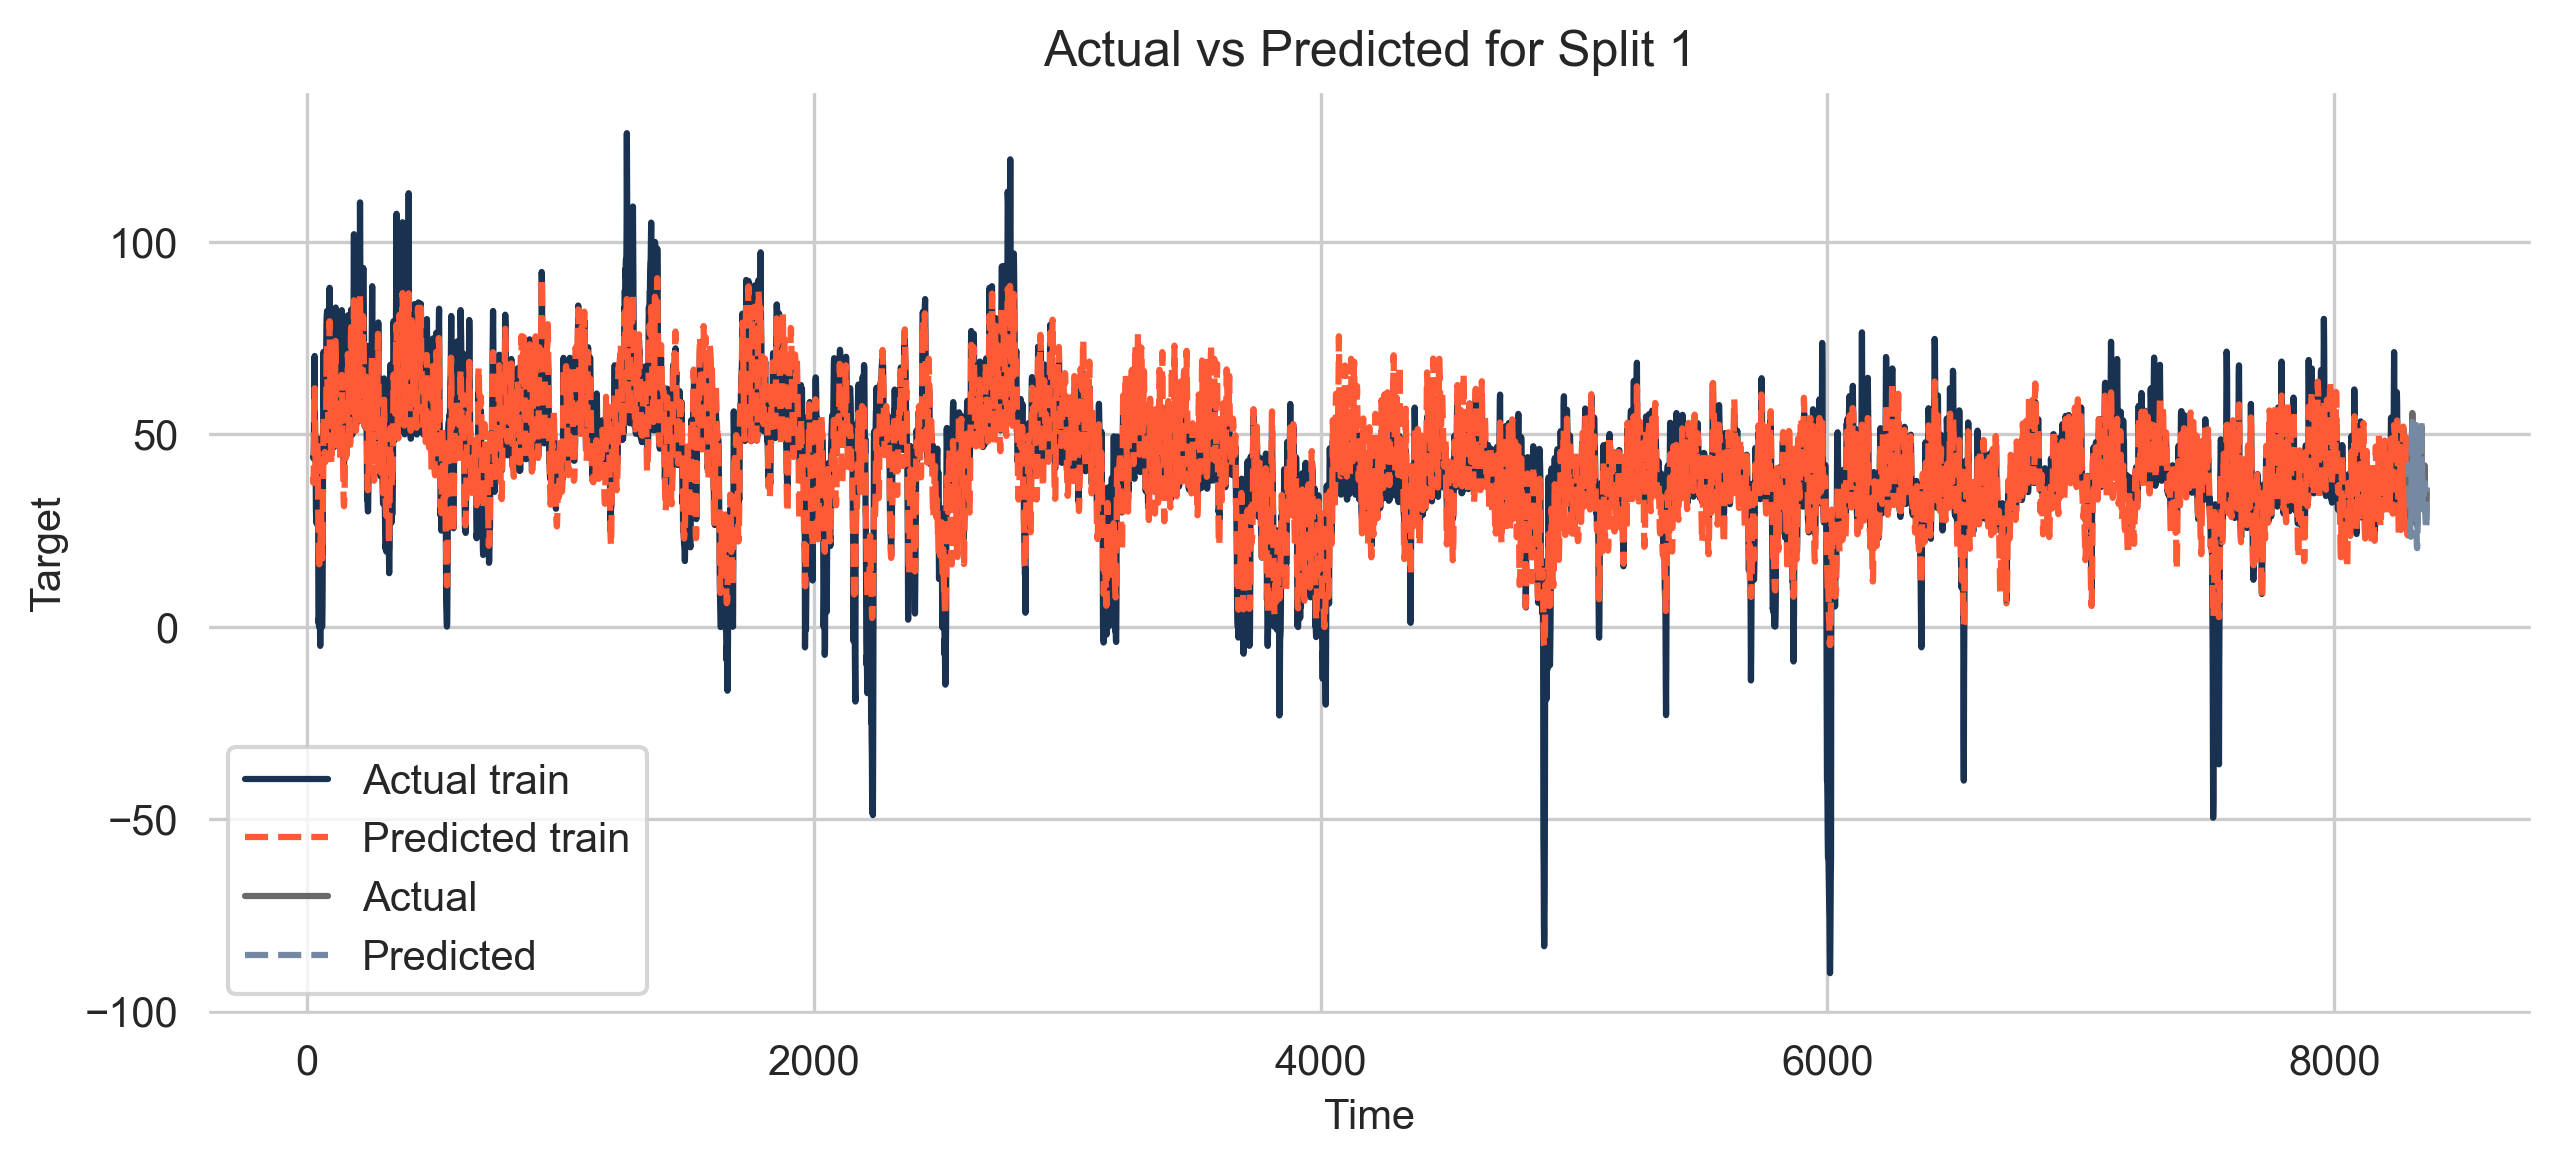

Split 1: Training data: (8270, 29), Validation data: (72, 29)
Training target: (8270,), Validation target: (72,)
MSE for Split 1: 12.081142316764206

[12.081142316764206, 71.71719743460078]


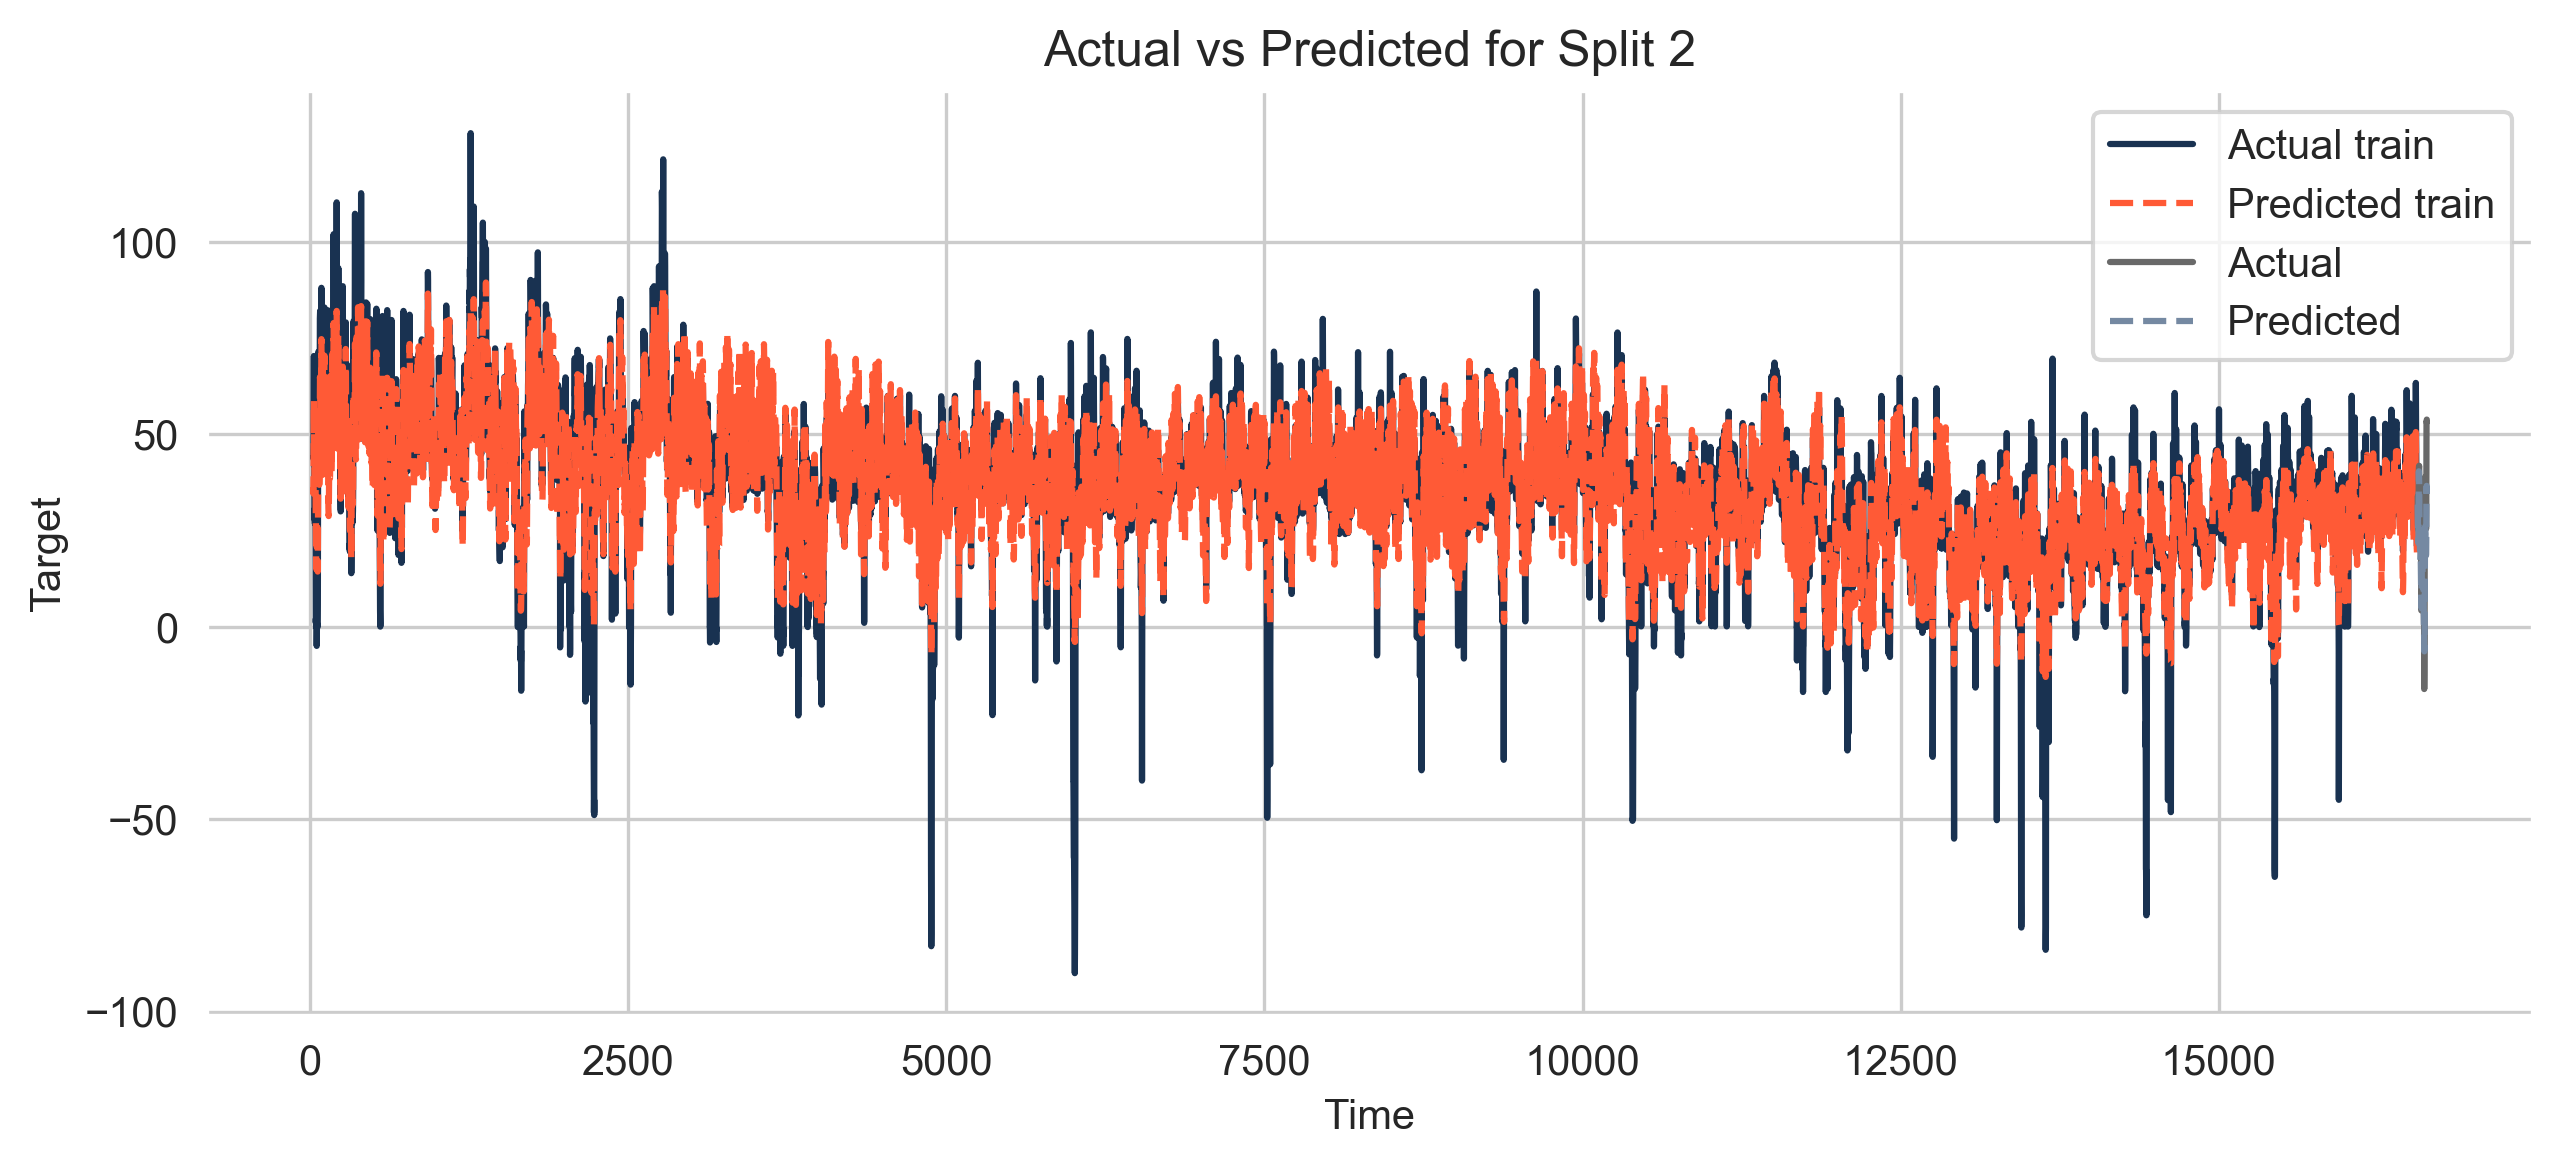

Split 2: Training data: (16540, 29), Validation data: (72, 29)
Training target: (16540,), Validation target: (72,)
MSE for Split 2: 71.71719743460078

[12.081142316764206, 71.71719743460078, 144.02676342072877]


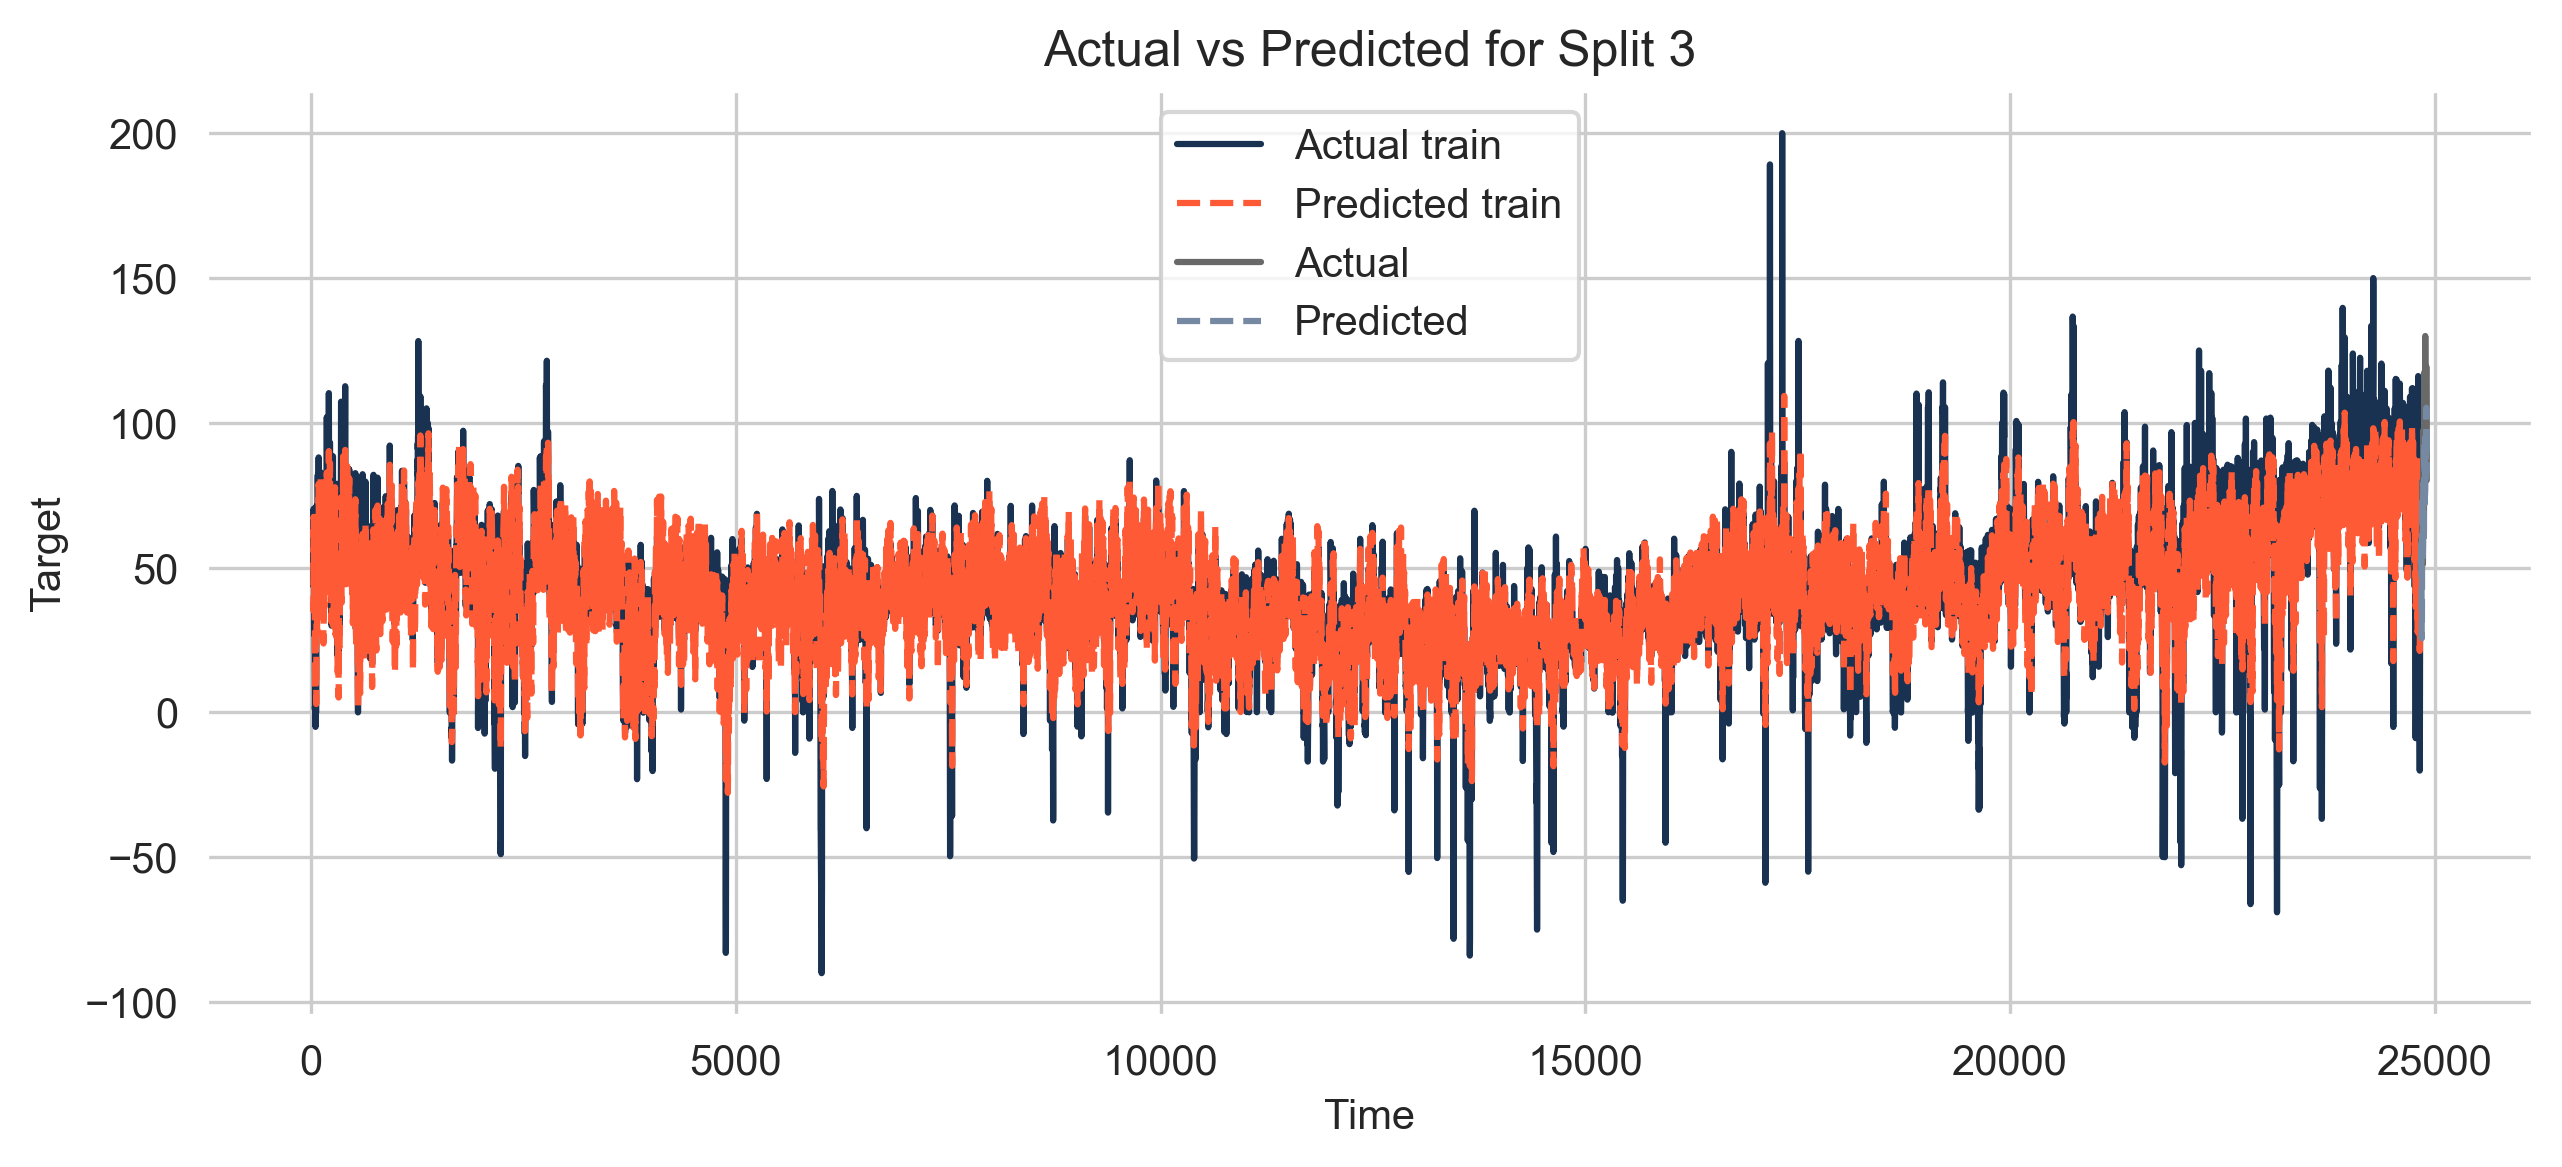

Split 3: Training data: (24810, 29), Validation data: (72, 29)
Training target: (24810,), Validation target: (72,)
MSE for Split 3: 144.02676342072877

[12.081142316764206, 71.71719743460078, 144.02676342072877, 7768.532534782459]


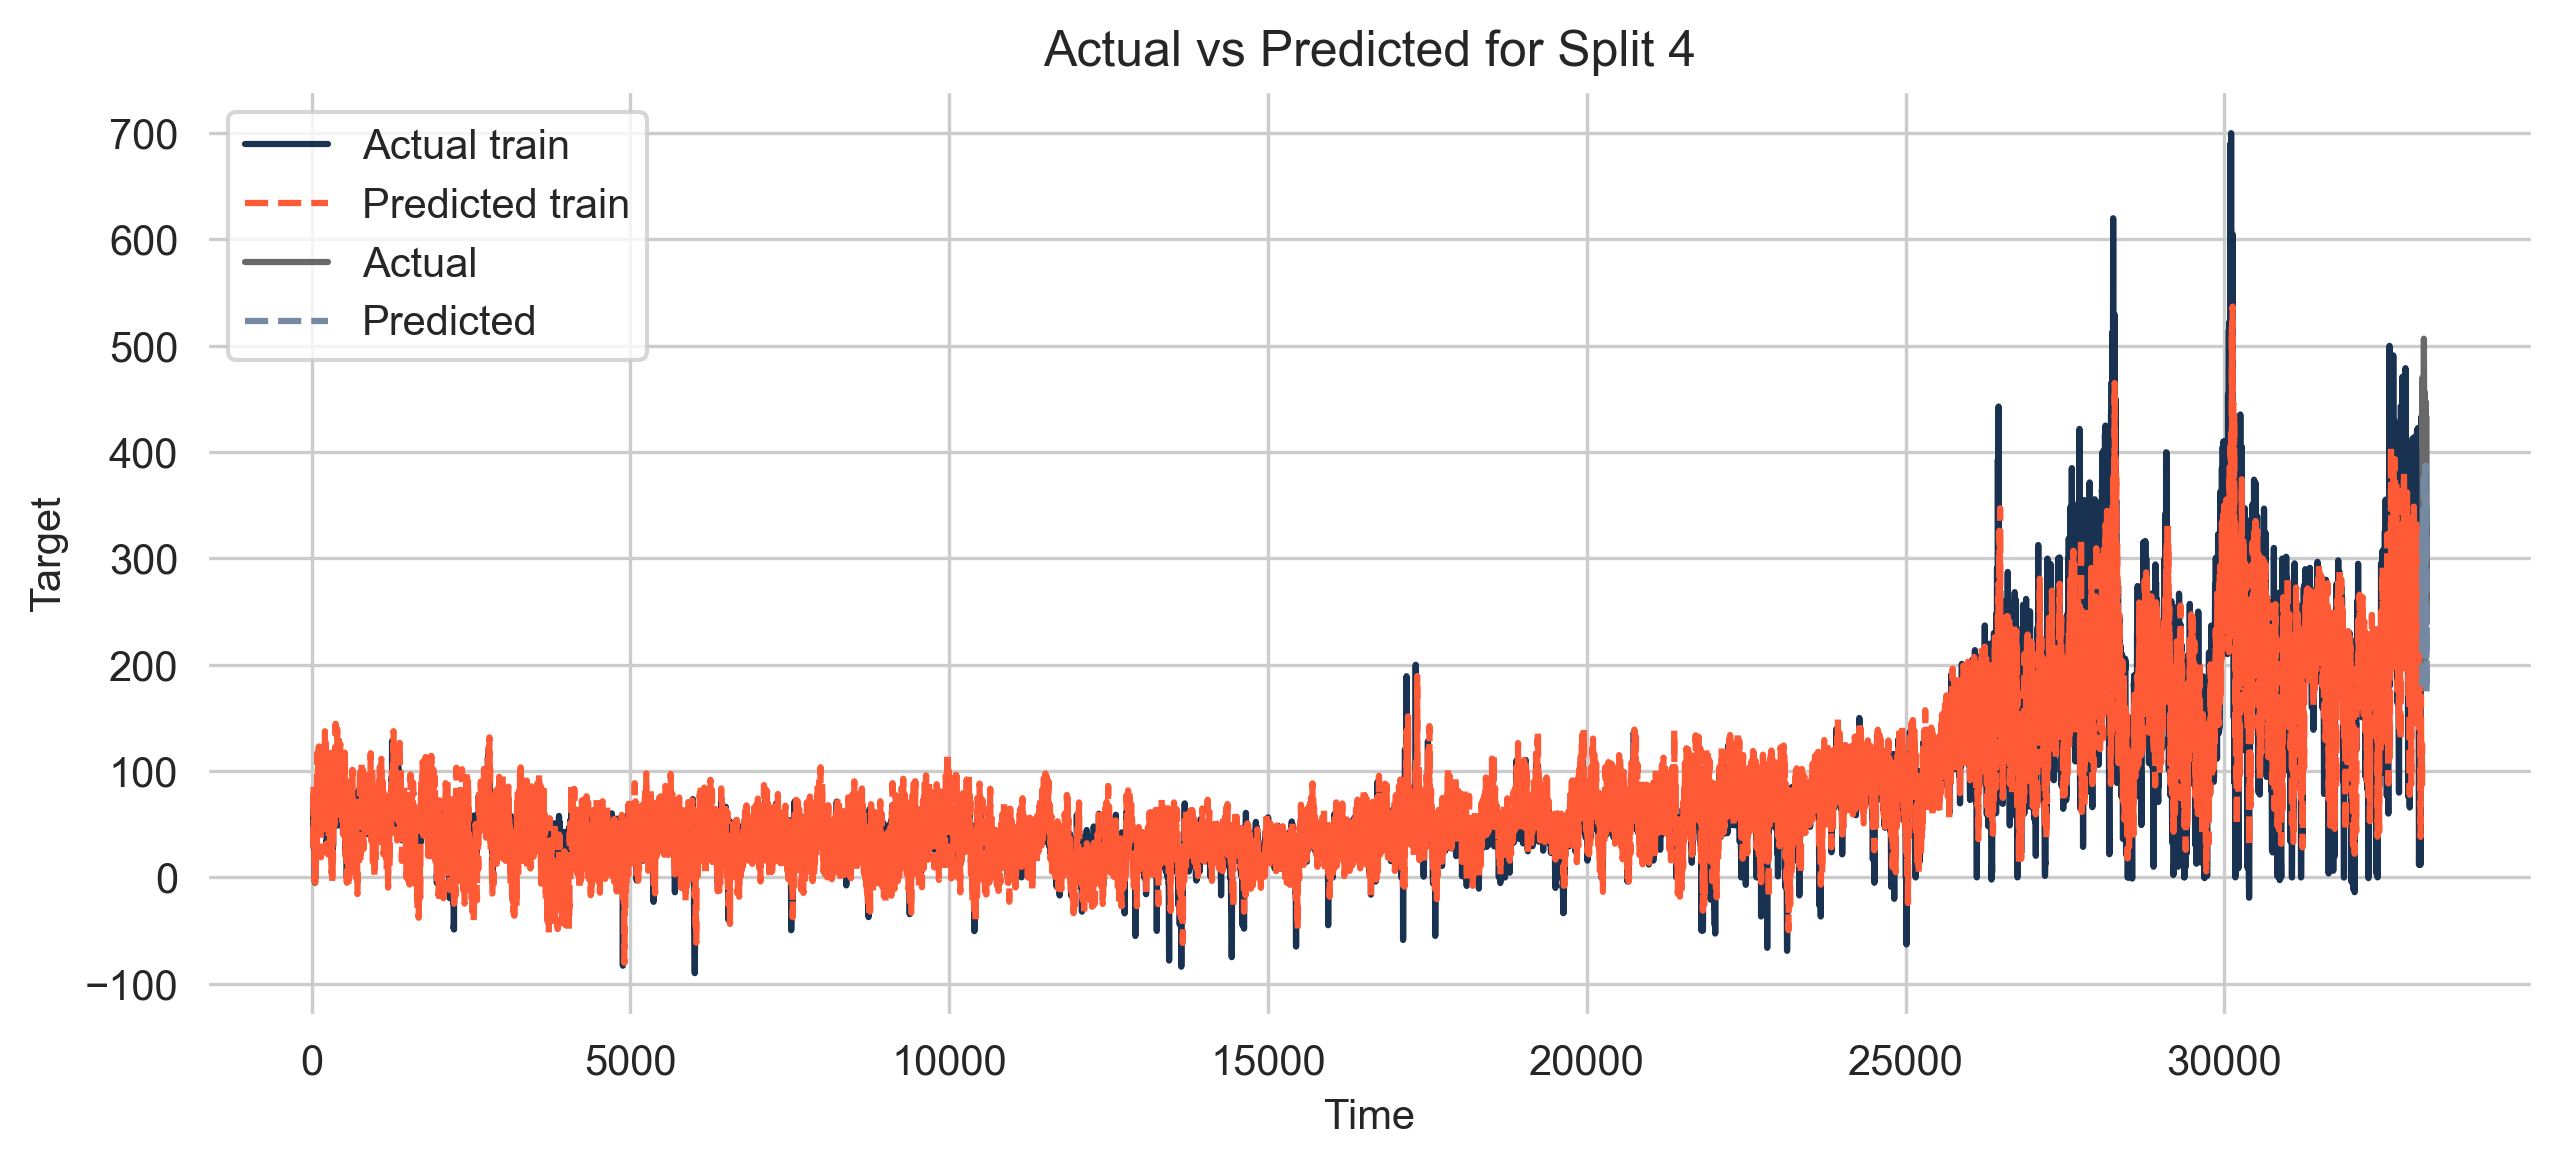

Split 4: Training data: (33080, 29), Validation data: (72, 29)
Training target: (33080,), Validation target: (72,)
MSE for Split 4: 7768.532534782459

[12.081142316764206, 71.71719743460078, 144.02676342072877, 7768.532534782459, 696.1438822552379]


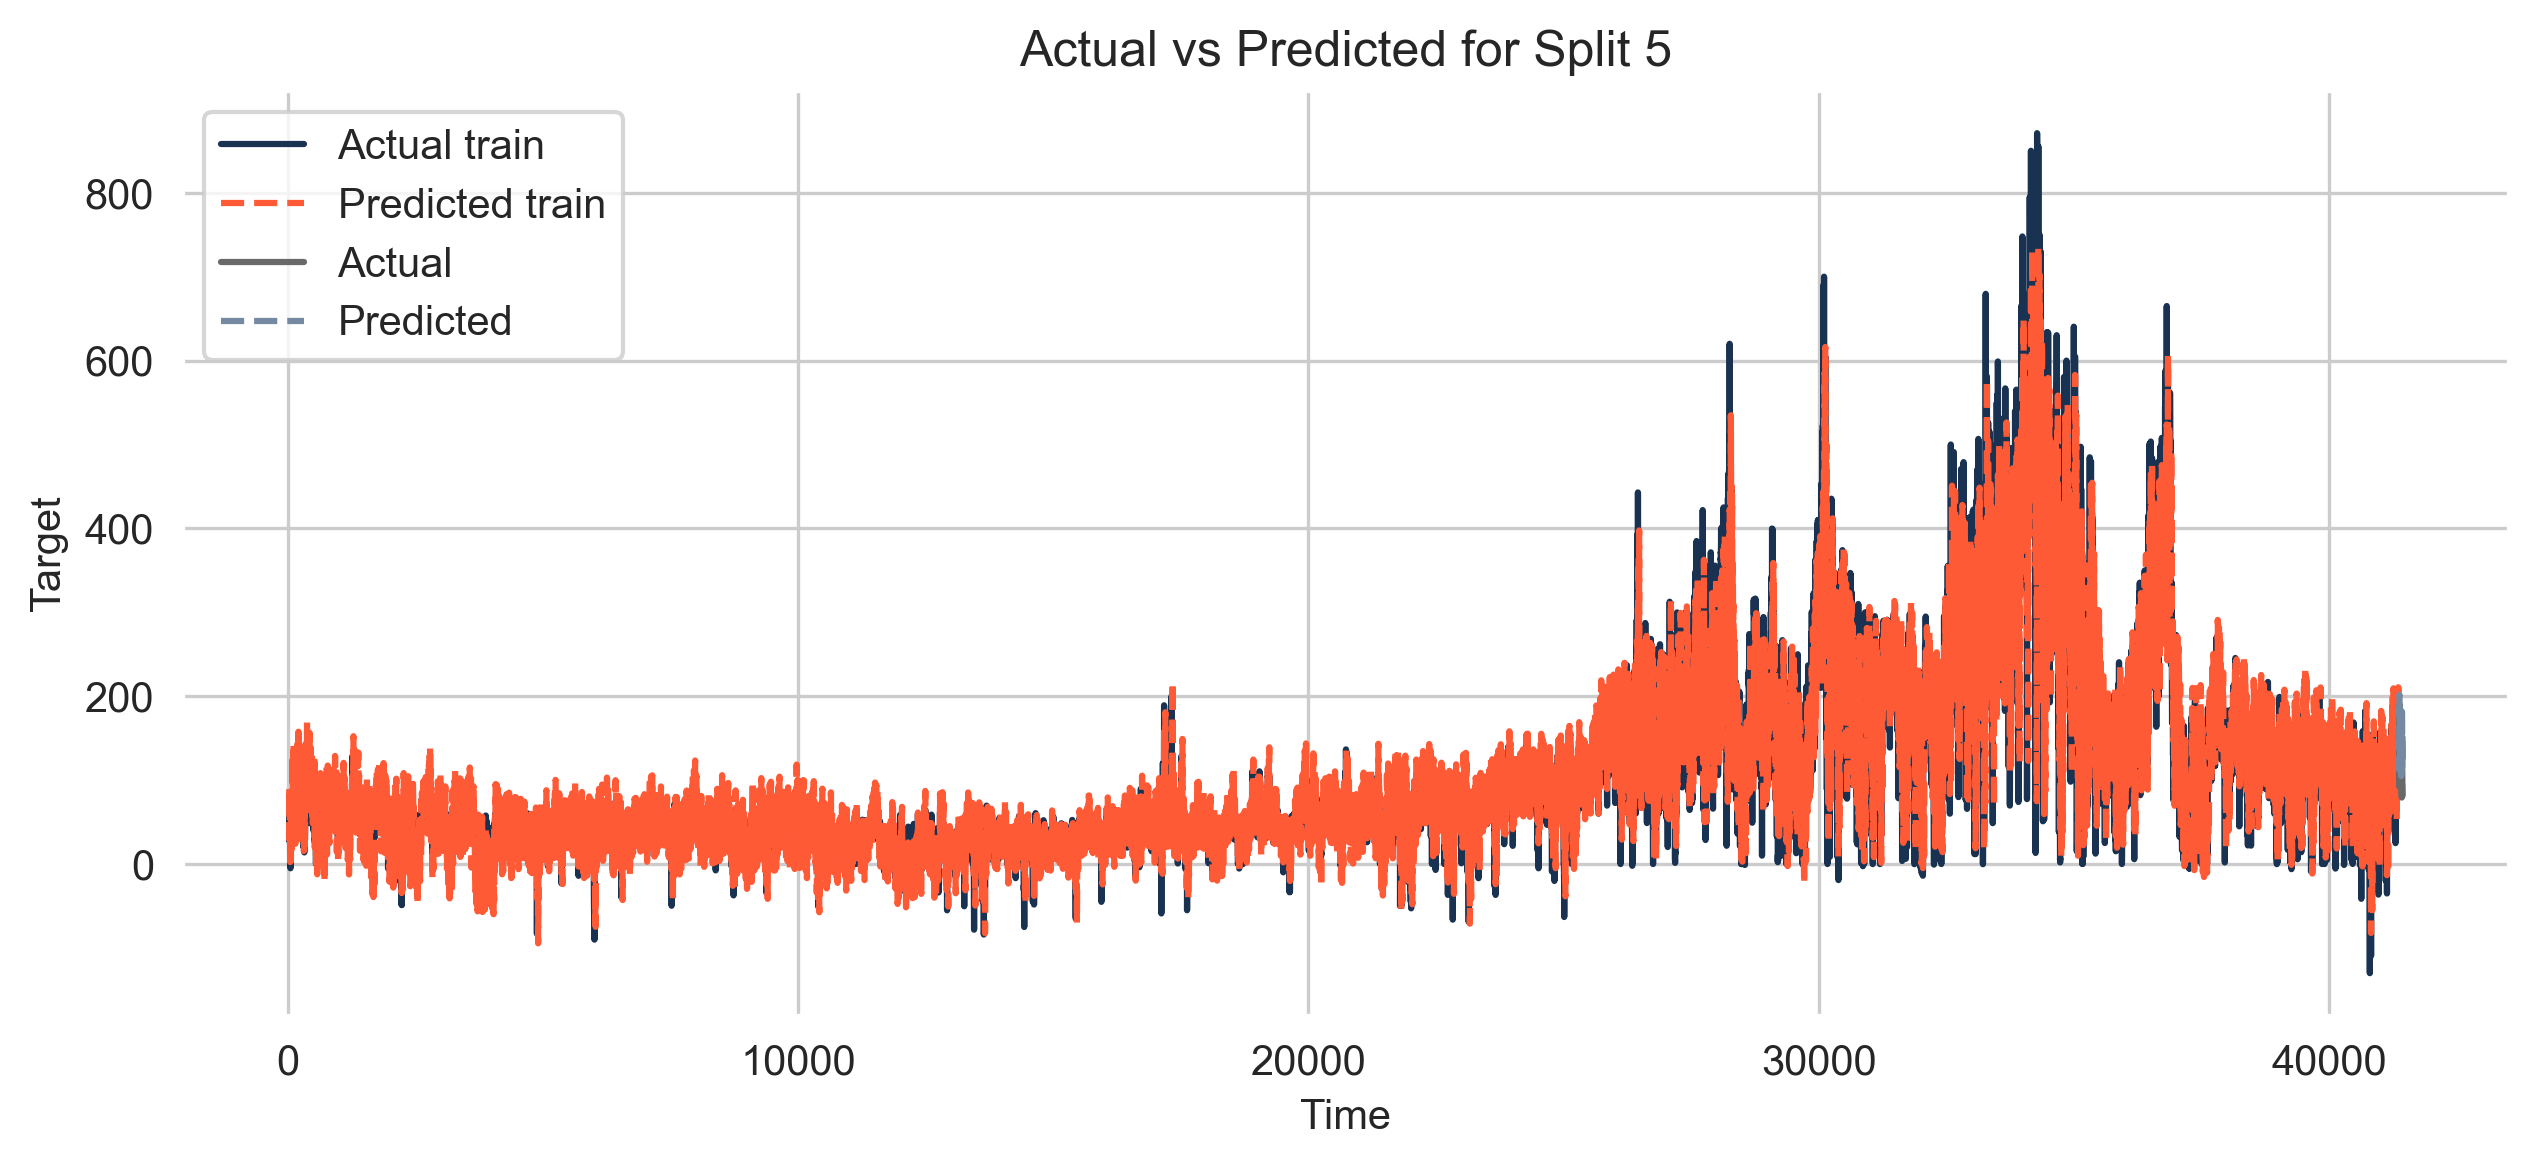

Split 5: Training data: (41350, 29), Validation data: (72, 29)
Training target: (41350,), Validation target: (72,)
MSE for Split 5: 696.1438822552379

Average MSE across all splits: 1738.5003040419583


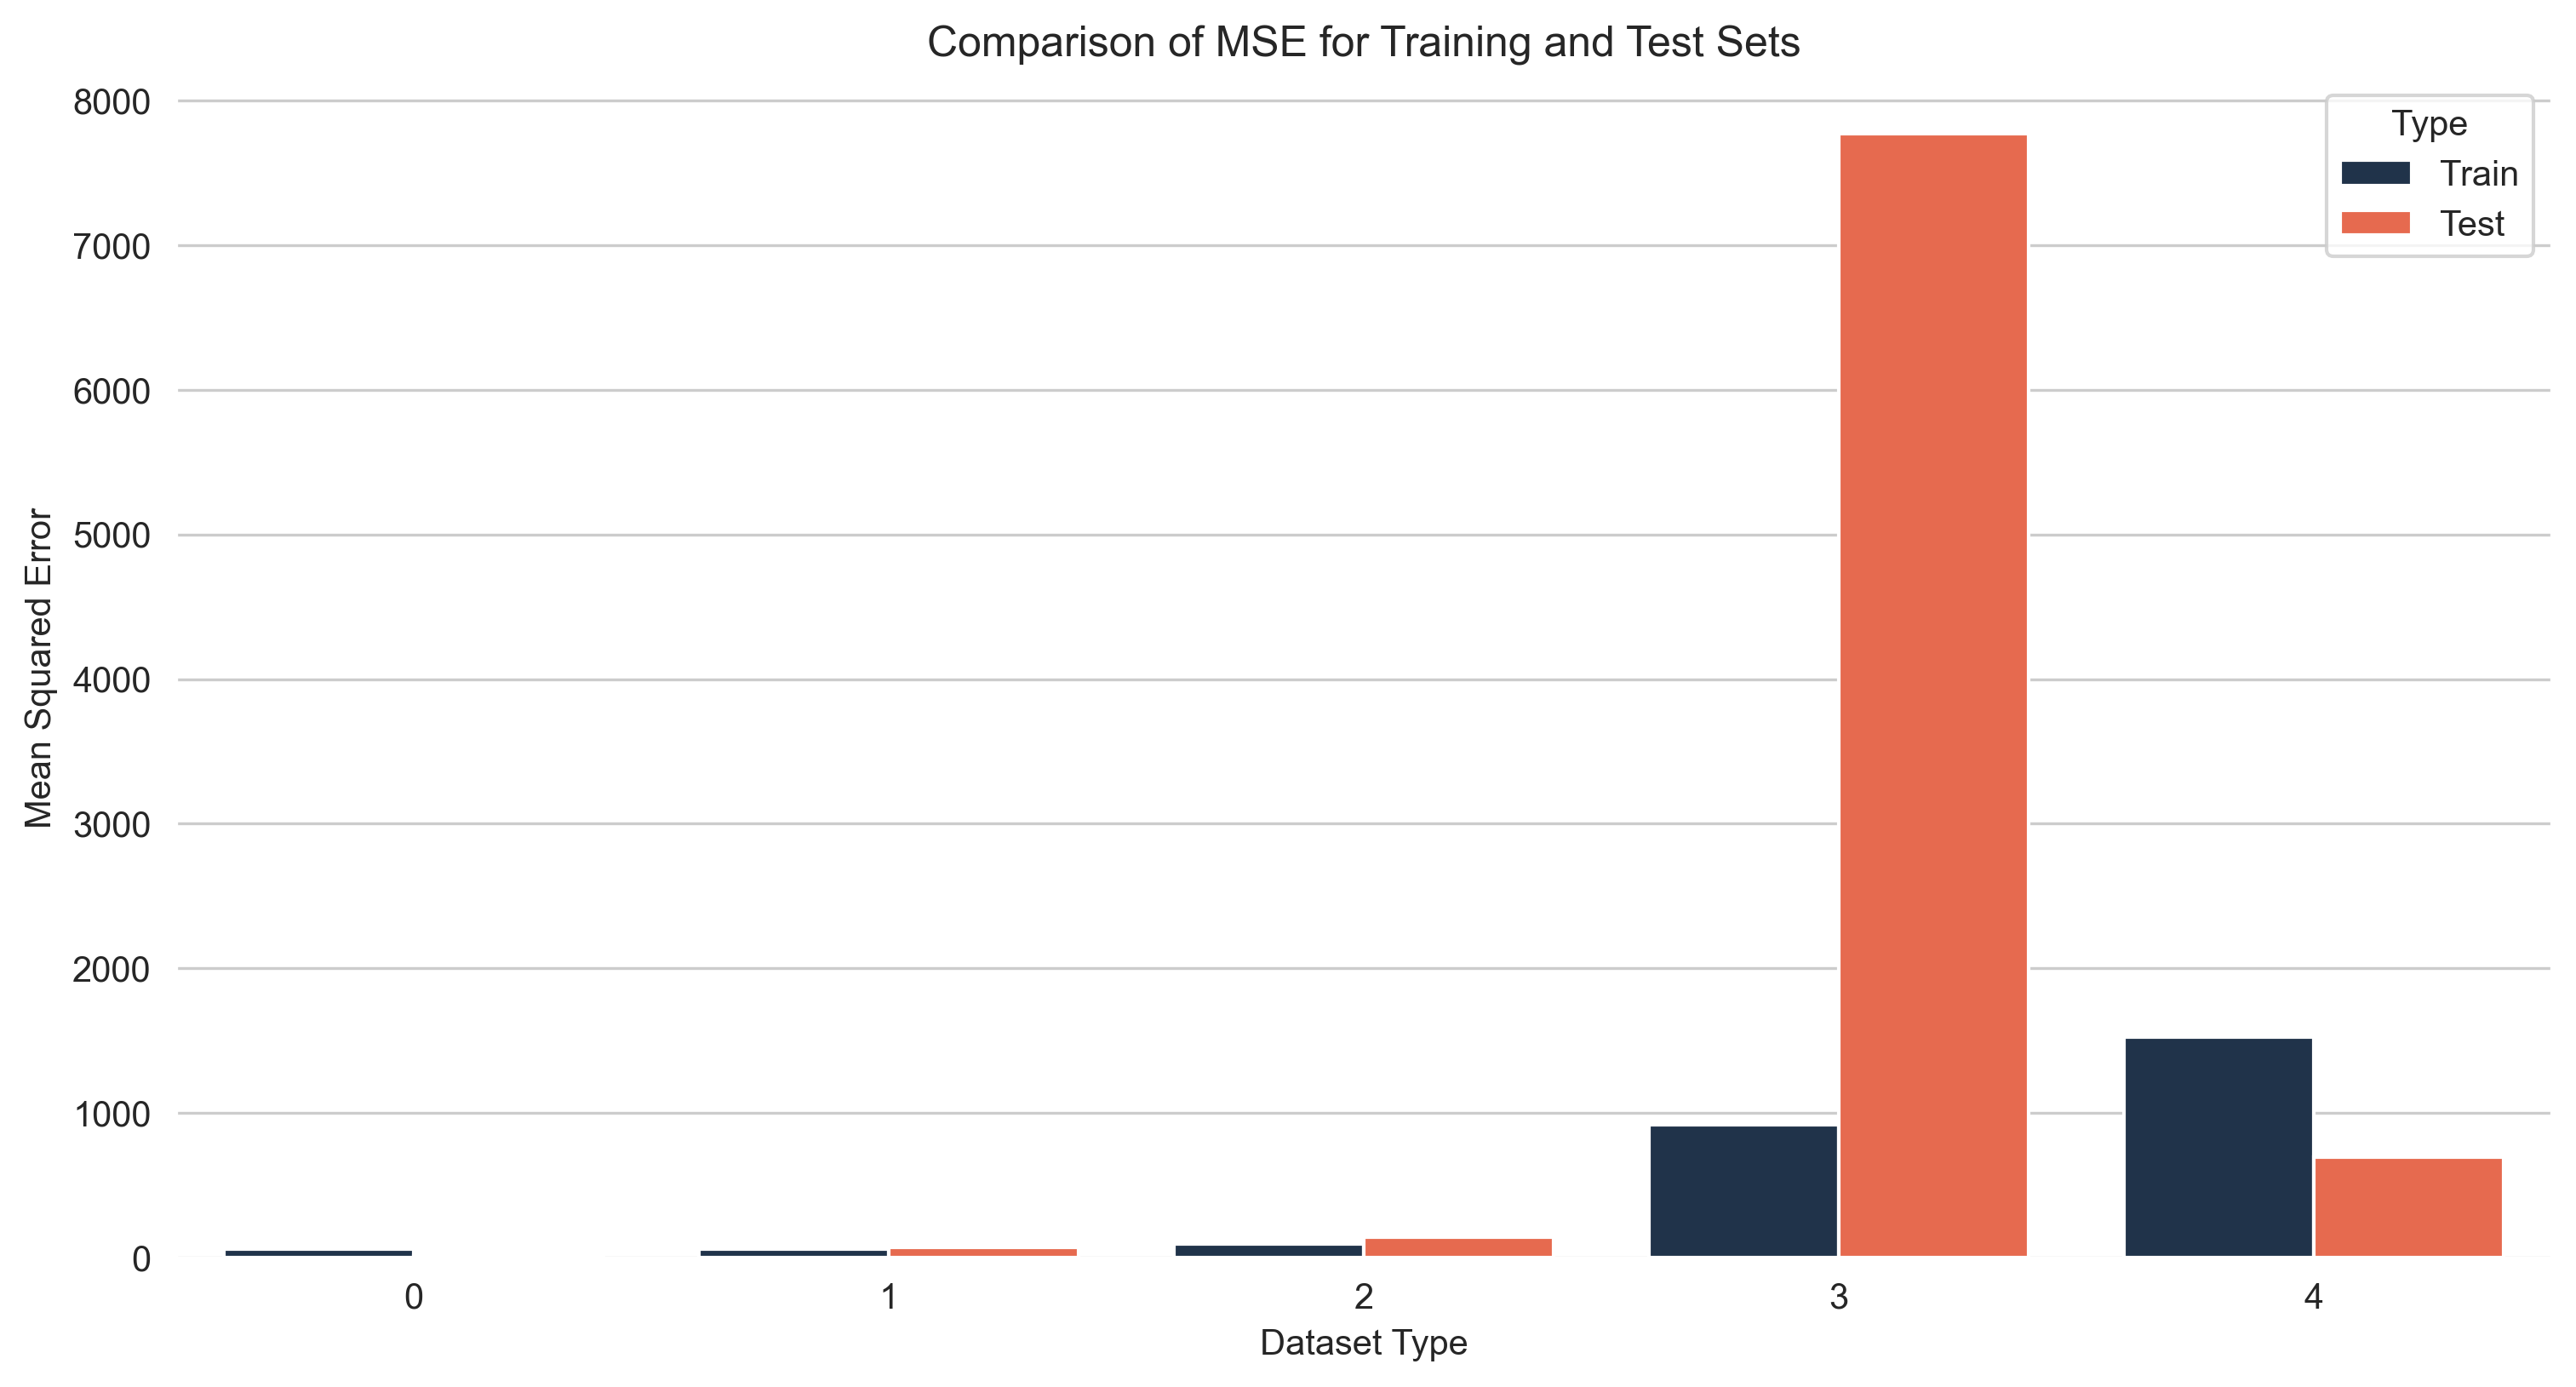

In [12]:
# Define number of splits and initial training set size
n_splits = 5
test_size = int(len(X) / (n_splits + 1))
print(test_size)
splits = []
mse_scores = []
mse_score_graph = []


for i in range(n_splits):
    train_end = (i + 1) * test_size
    test_end = train_end + 72
    
    # Ensure train_end and test_end do not go beyond the length of the dataset

    if test_end > len(X):
        test_end = len(X)

    X_train = X.iloc[:train_end]
    y_train = y.iloc[:train_end]
    X_test = X.iloc[train_end:test_end]
    y_test = y.iloc[train_end:test_end]
    
    scaler = StandardScaler()

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    # Ensure no sets are empty
    #f len(X_train) == 0 or len(X_test) == 0 or len(y_train) == 0 or len(y_test) == 0:
    #    break
    
    splits.append((X_train_scaled, X_test_scaled, y_train, y_test))
    
    # Initialize and train logistic regression model
    m_linreg = LinearRegression()
    m_linreg.fit(X_train_scaled, y_train)
    
    # Make predictions on the test set
    y_pred = m_linreg.predict(X_test_scaled)
    y_pred_train = m_linreg.predict(X_train_scaled)
    y_pred_test = y_pred
    

    # Calculate accuracy
    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)
    print(mse_scores)

    # Plotting
    plt.figure(figsize=(10, 4))
    sns.lineplot(x=y_train.index, y=y_train, label= 'Actual train' )
    sns.lineplot(x=y_train.index, y=y_pred_train, label= 'Predicted train', linestyle = '--')
    sns.lineplot(x=y_test.index, y=y_test, label='Actual')
    sns.lineplot(x=y_test.index, y=y_pred, label='Predicted', linestyle='--')
    plt.title(f'Actual vs Predicted for Split {i+1}')
    plt.xlabel('Time')
    plt.ylabel('Target')
    plt.legend()
    plt.show()

    print(f"Split {i+1}: Training data: {X_train.shape}, Validation data: {X_test.shape}")
    print(f"Training target: {y_train.shape}, Validation target: {y_test.shape}")
    print(f"MSE for Split {i+1}: {mse}\n")

    # Calculate MSE 
    mse_train = mean_squared_error(y_train, y_pred_train) 
    mse_test = mean_squared_error(y_test, y_pred_test) 
    # Prepare data for seaborn 
    mse_comparison = pd.DataFrame({ 'Type': ['Train', 'Test'], 'MSE': [mse_train, mse_test], 'split': [i, i] }) 
    mse_score_graph.append(mse_comparison)
     


# Optional: Average MSE across all splits for overall evaluation
average_mse = sum(mse_scores) / len(mse_scores)
print(f"Average MSE across all splits: {average_mse}")
mse_score_sum = pd.concat(mse_score_graph, axis=0)
mse_score_sum['split'] = mse_score_sum['split'].astype(int)

# Plot using seaborn
sns.barplot(x='split', y='MSE', hue='Type', data=mse_score_sum) 
plt.title('Comparison of MSE for Training and Test Sets') 
plt.ylabel('Mean Squared Error') 
plt.xlabel('Dataset Type') 
plt.show()


ADF Test:
Null Hypothesis: Not Stationary
ADF Statistic: -7.493250
p-value: 0.000000
----------------------------------------
KPSS Test:
Null Hypothesis: Stationary
KPSS Statistic: 22.354259
p-value: 0.010000
----------------------------------------


/var/folders/2h/f8y8jw1j16l2sryb7gpgwhlw0000gn/T/ipykernel_5861/3467084946.py:28: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = kpss(stock_close_price, regression='c', nlags="legacy", store=False)


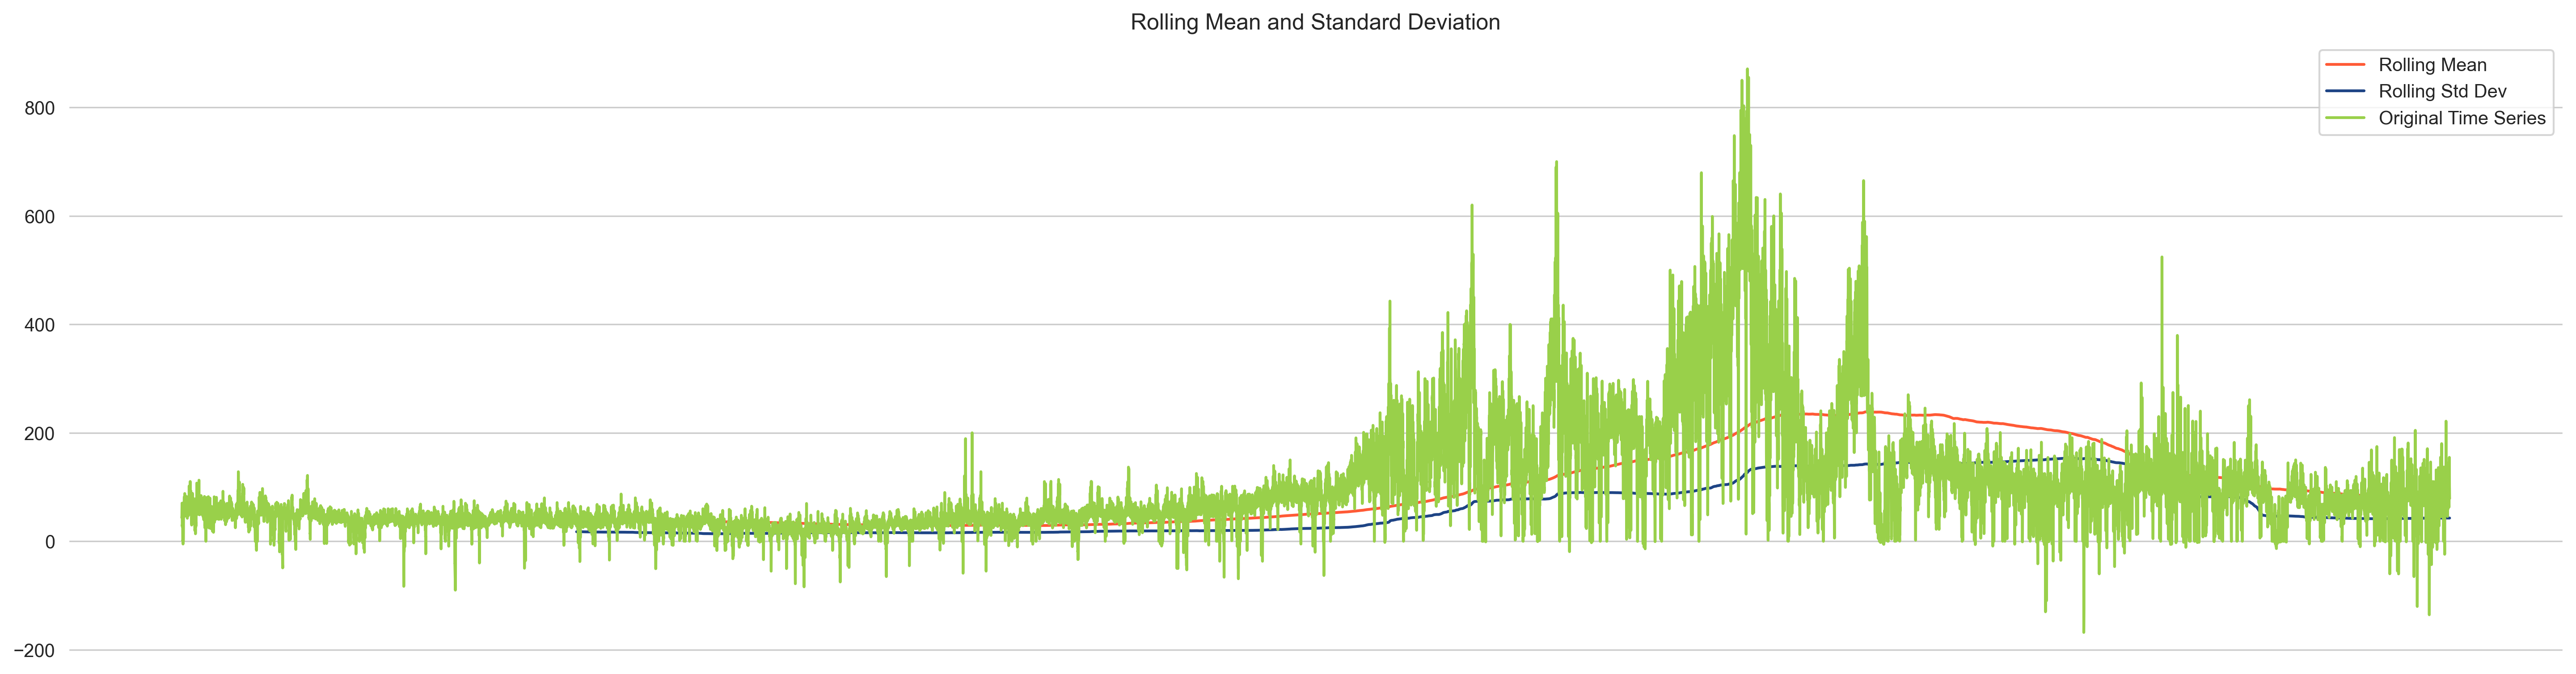

In [19]:
# Test for stationarity 

def stationarity_test(stock_close_price):
    
    # Calculate rolling mean and rolling standard deviation
    rolling_mean = stock_close_price.rolling(720*4*3).mean()
    rolling_std_dev = stock_close_price.rolling(720*4*3).std()
    
    # Plot the statistics
    plt.figure(figsize=(24,6))
    plt.plot(rolling_mean, color='#FF5A36', label='Rolling Mean')
    plt.plot(rolling_std_dev, color='#1E4485', label = 'Rolling Std Dev')
    plt.plot(stock_close_price, color='#99D04A',label='Original Time Series')
    plt.xticks([])
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    
    # ADF test
    print("ADF Test:")
    adf_test = adfuller(stock_close_price,autolag='AIC')
    print('Null Hypothesis: Not Stationary')
    print('ADF Statistic: %f' % adf_test[0])
    print('p-value: %f' % adf_test[1])
    print('----'*10)
    
    # KPSS test
    print("KPSS Test:")
    kpss_test = kpss(stock_close_price, regression='c', nlags="legacy", store=False)
    print('Null Hypothesis: Stationary')
    print('KPSS Statistic: %f' % kpss_test[0])
    print('p-value: %f' % kpss_test[1])
    print('----'*10)
    
stationarity_test(df_linreg['germany_luxembourg_eur_mwh'])

In [14]:
mse_score_sum.head()

,Type,MSE,split
0,Train,62.654014,0
1,Test,12.081142,0
0,Train,59.291977,1
1,Test,71.717197,1
0,Train,97.072912,2


Initial train size: 8270, Test size: 72
[12.08114231681924]


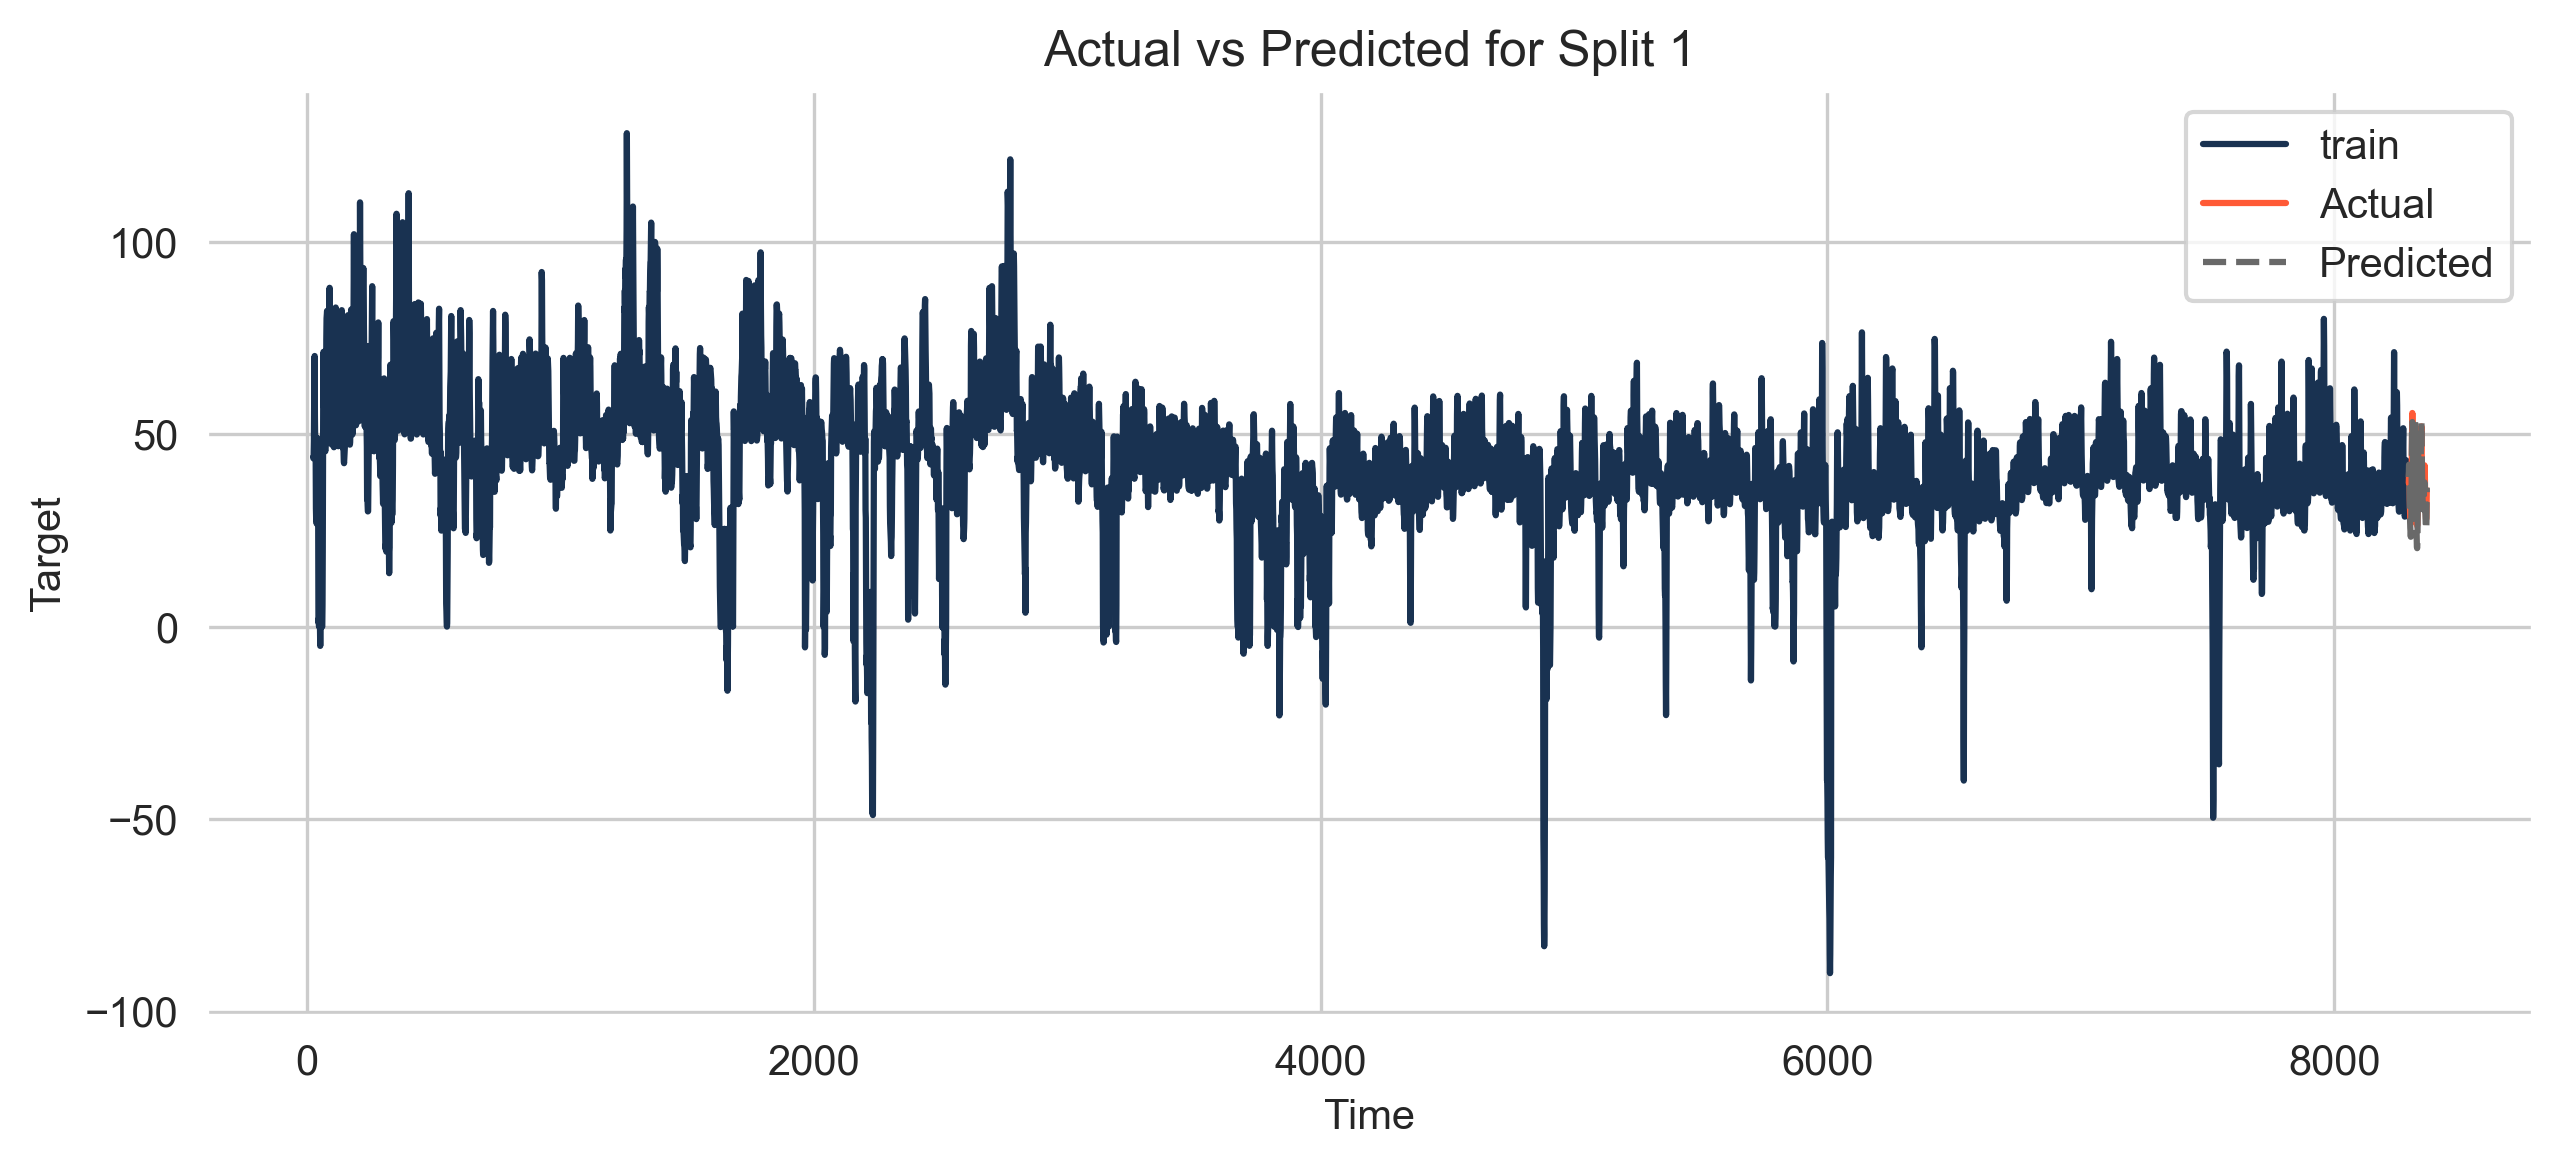

Split 1: Training data: (8270, 29), Validation data: (72, 29)
Training target: (8270,), Validation target: (72,)
MSE for Split 1: 12.08114231681924

[12.08114231681924, 64.99893316072851]


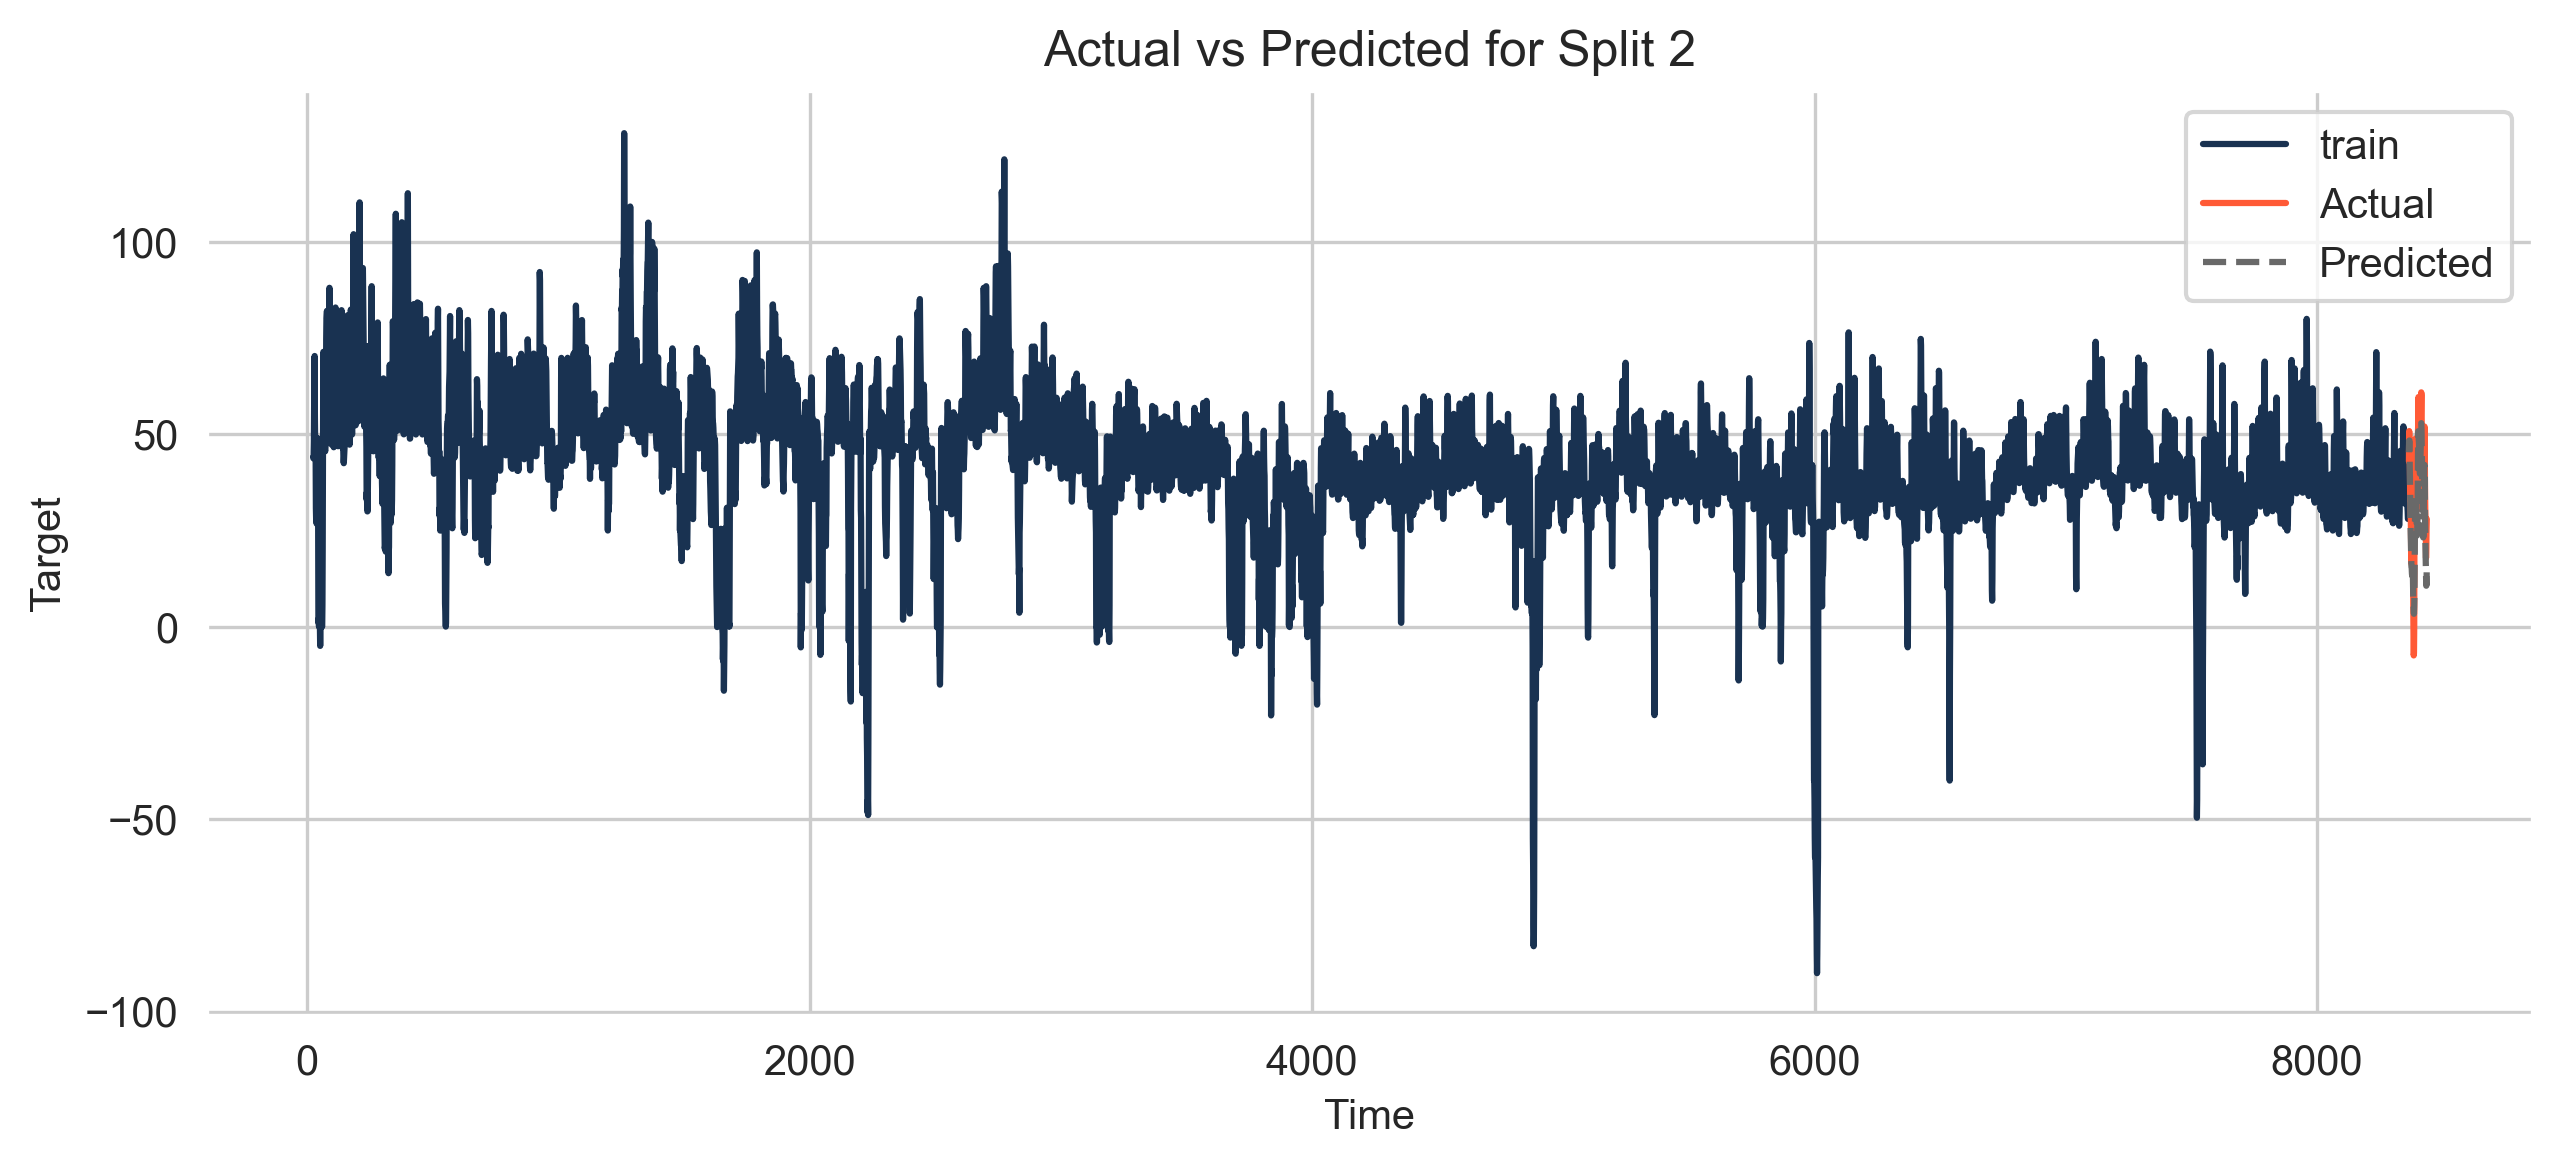

Split 2: Training data: (8342, 29), Validation data: (72, 29)
Training target: (8342,), Validation target: (72,)
MSE for Split 2: 64.99893316072851

[12.08114231681924, 64.99893316072851, 42.310728363649346]


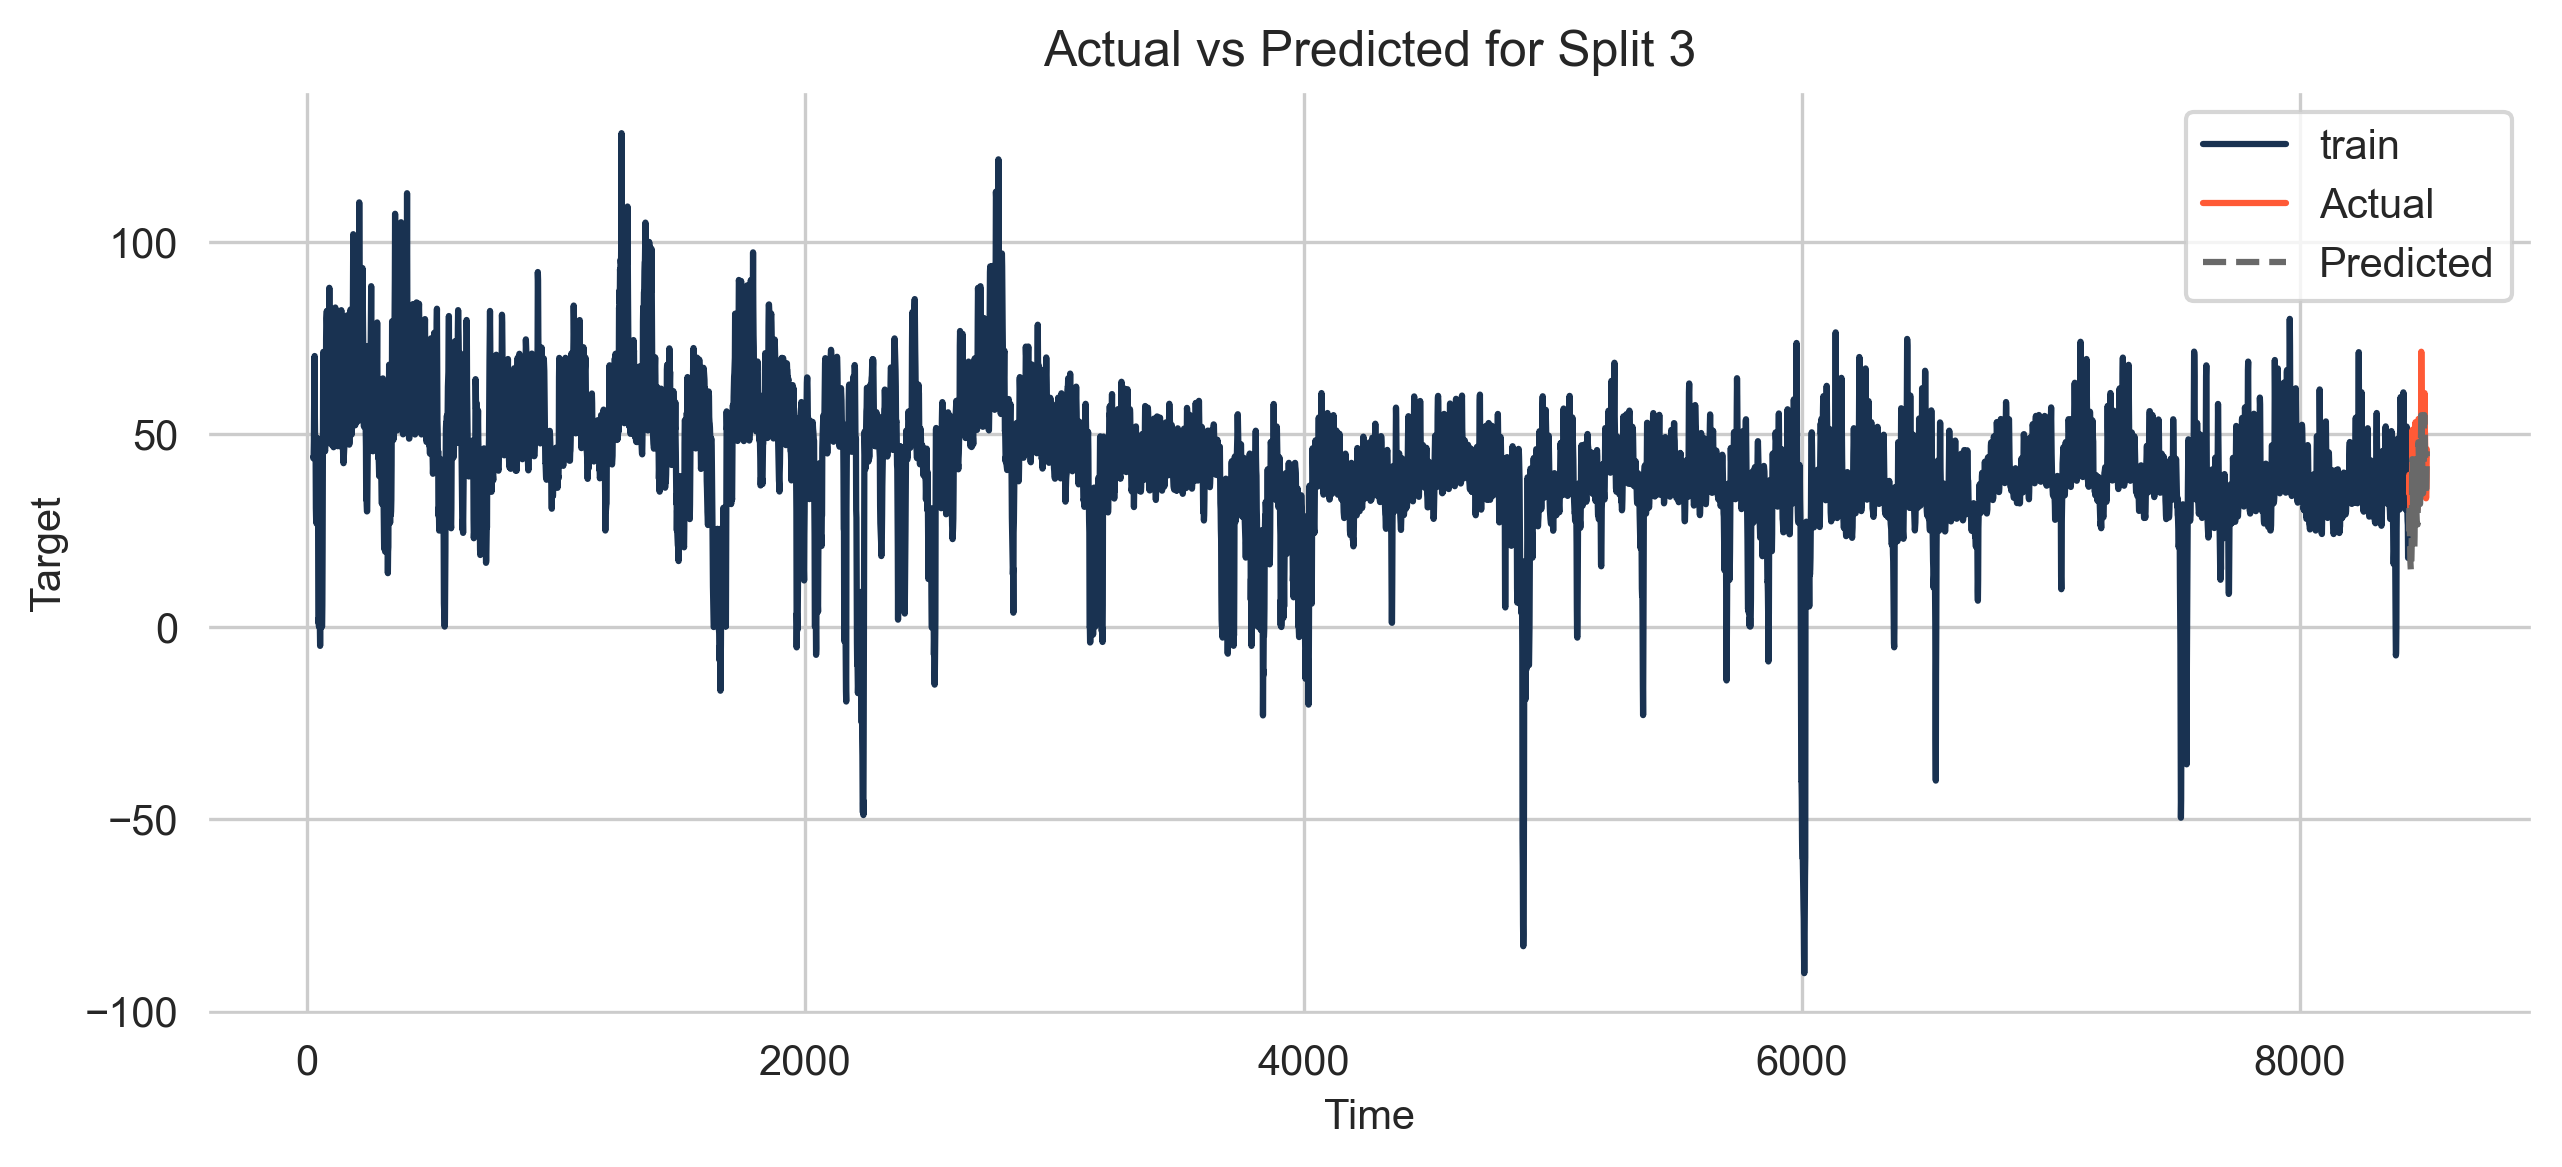

Split 3: Training data: (8414, 29), Validation data: (72, 29)
Training target: (8414,), Validation target: (72,)
MSE for Split 3: 42.310728363649346

[12.08114231681924, 64.99893316072851, 42.310728363649346, 14.011989036207627]


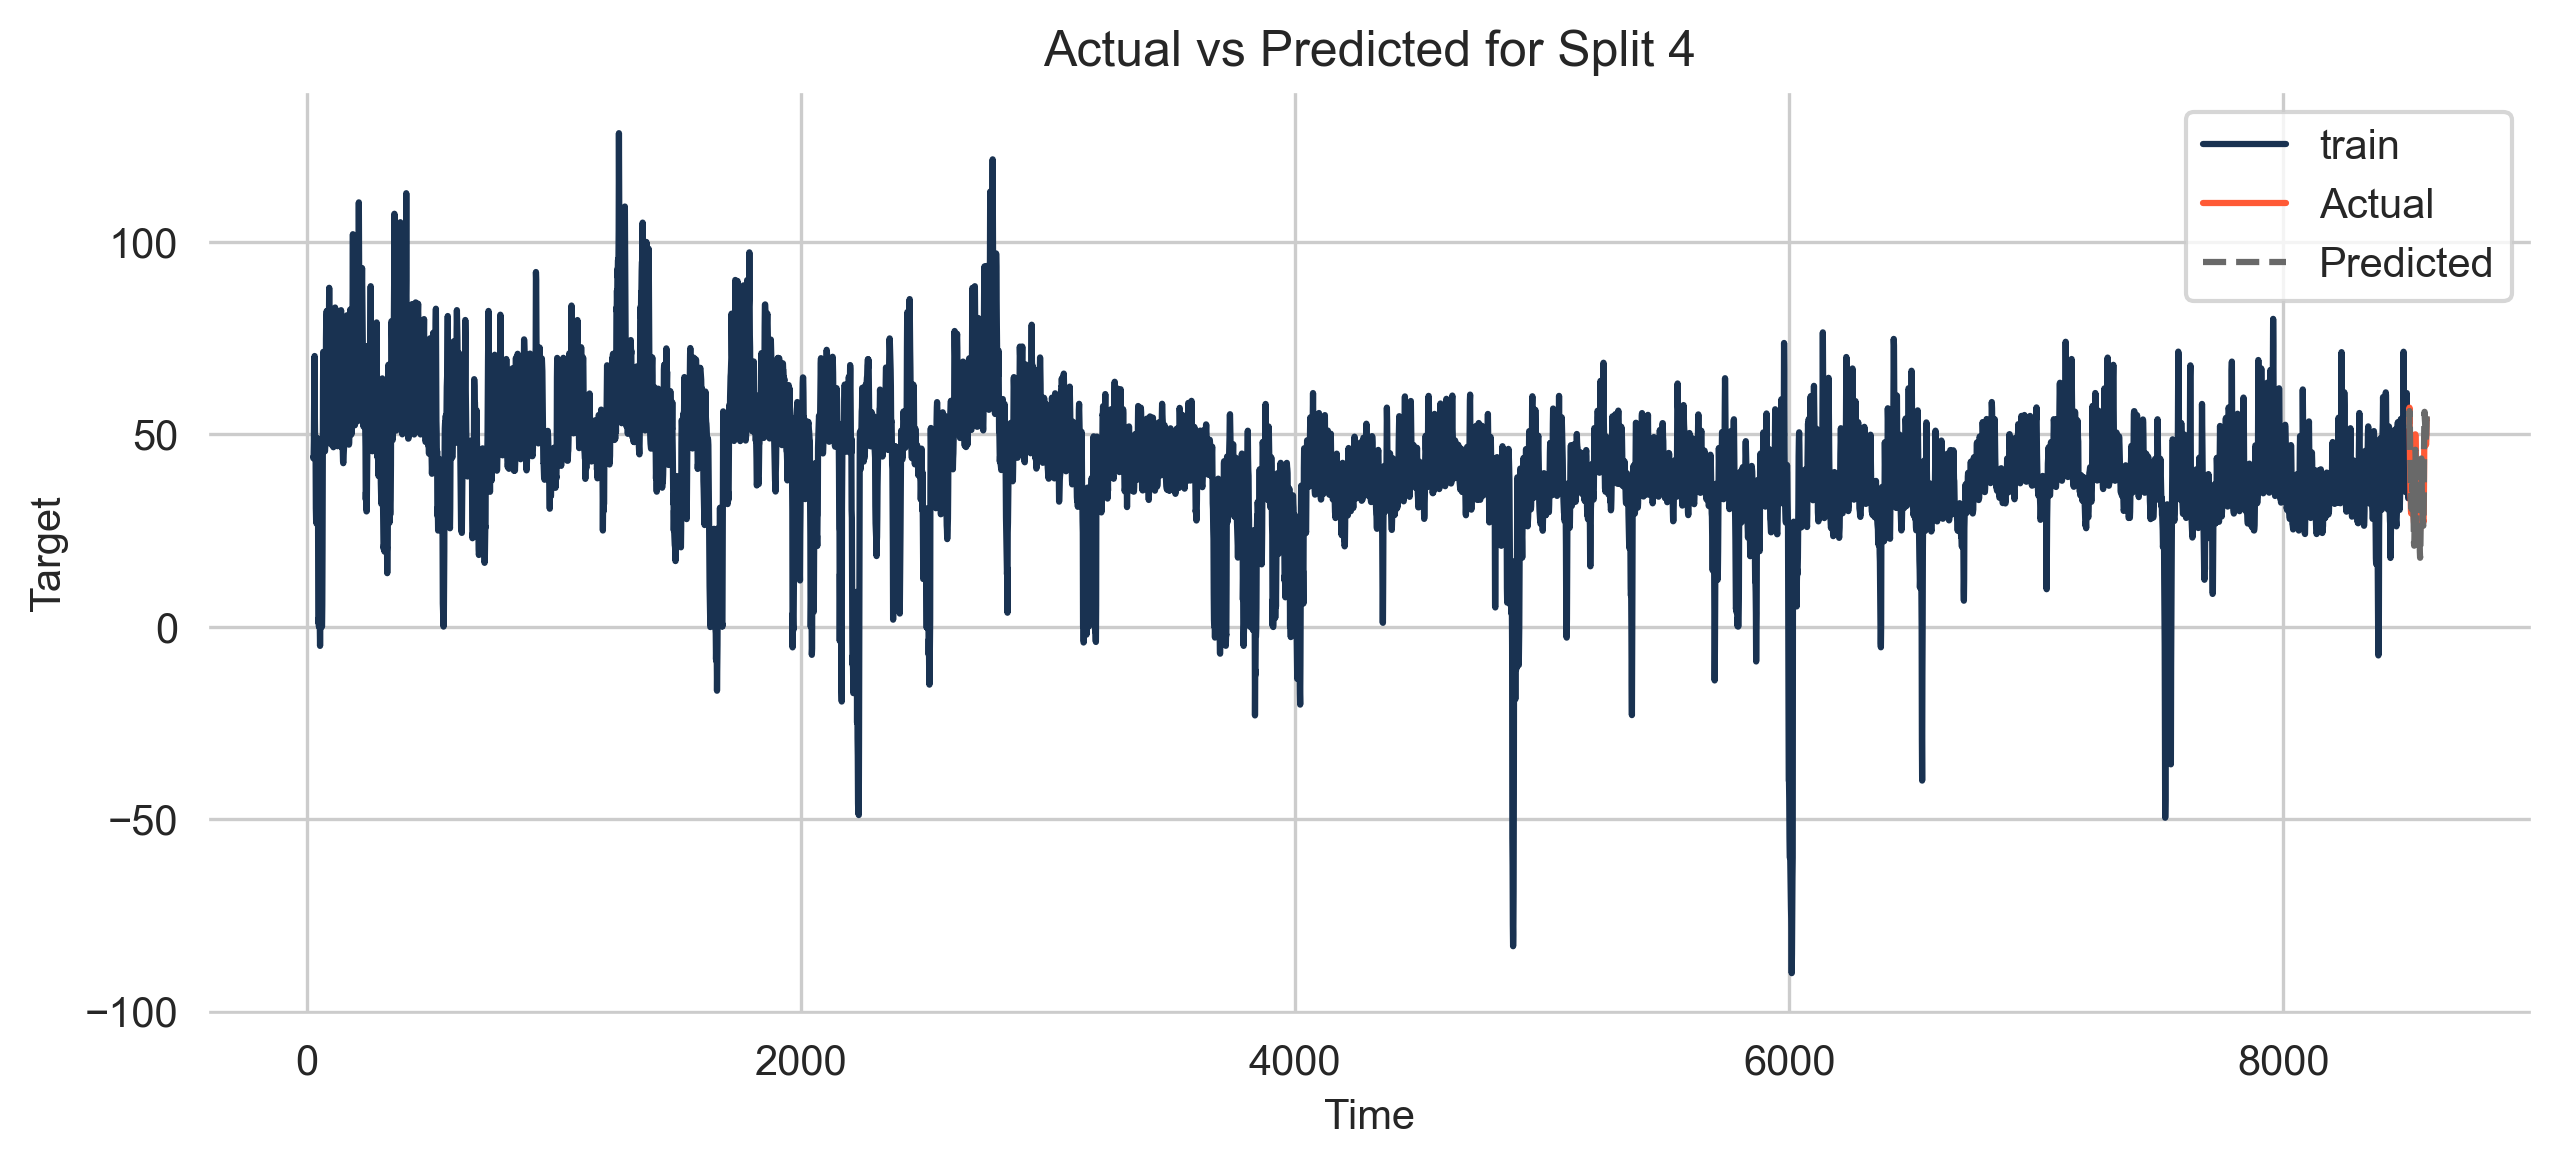

Split 4: Training data: (8486, 29), Validation data: (72, 29)
Training target: (8486,), Validation target: (72,)
MSE for Split 4: 14.011989036207627

[12.08114231681924, 64.99893316072851, 42.310728363649346, 14.011989036207627, 24.994742392808128]


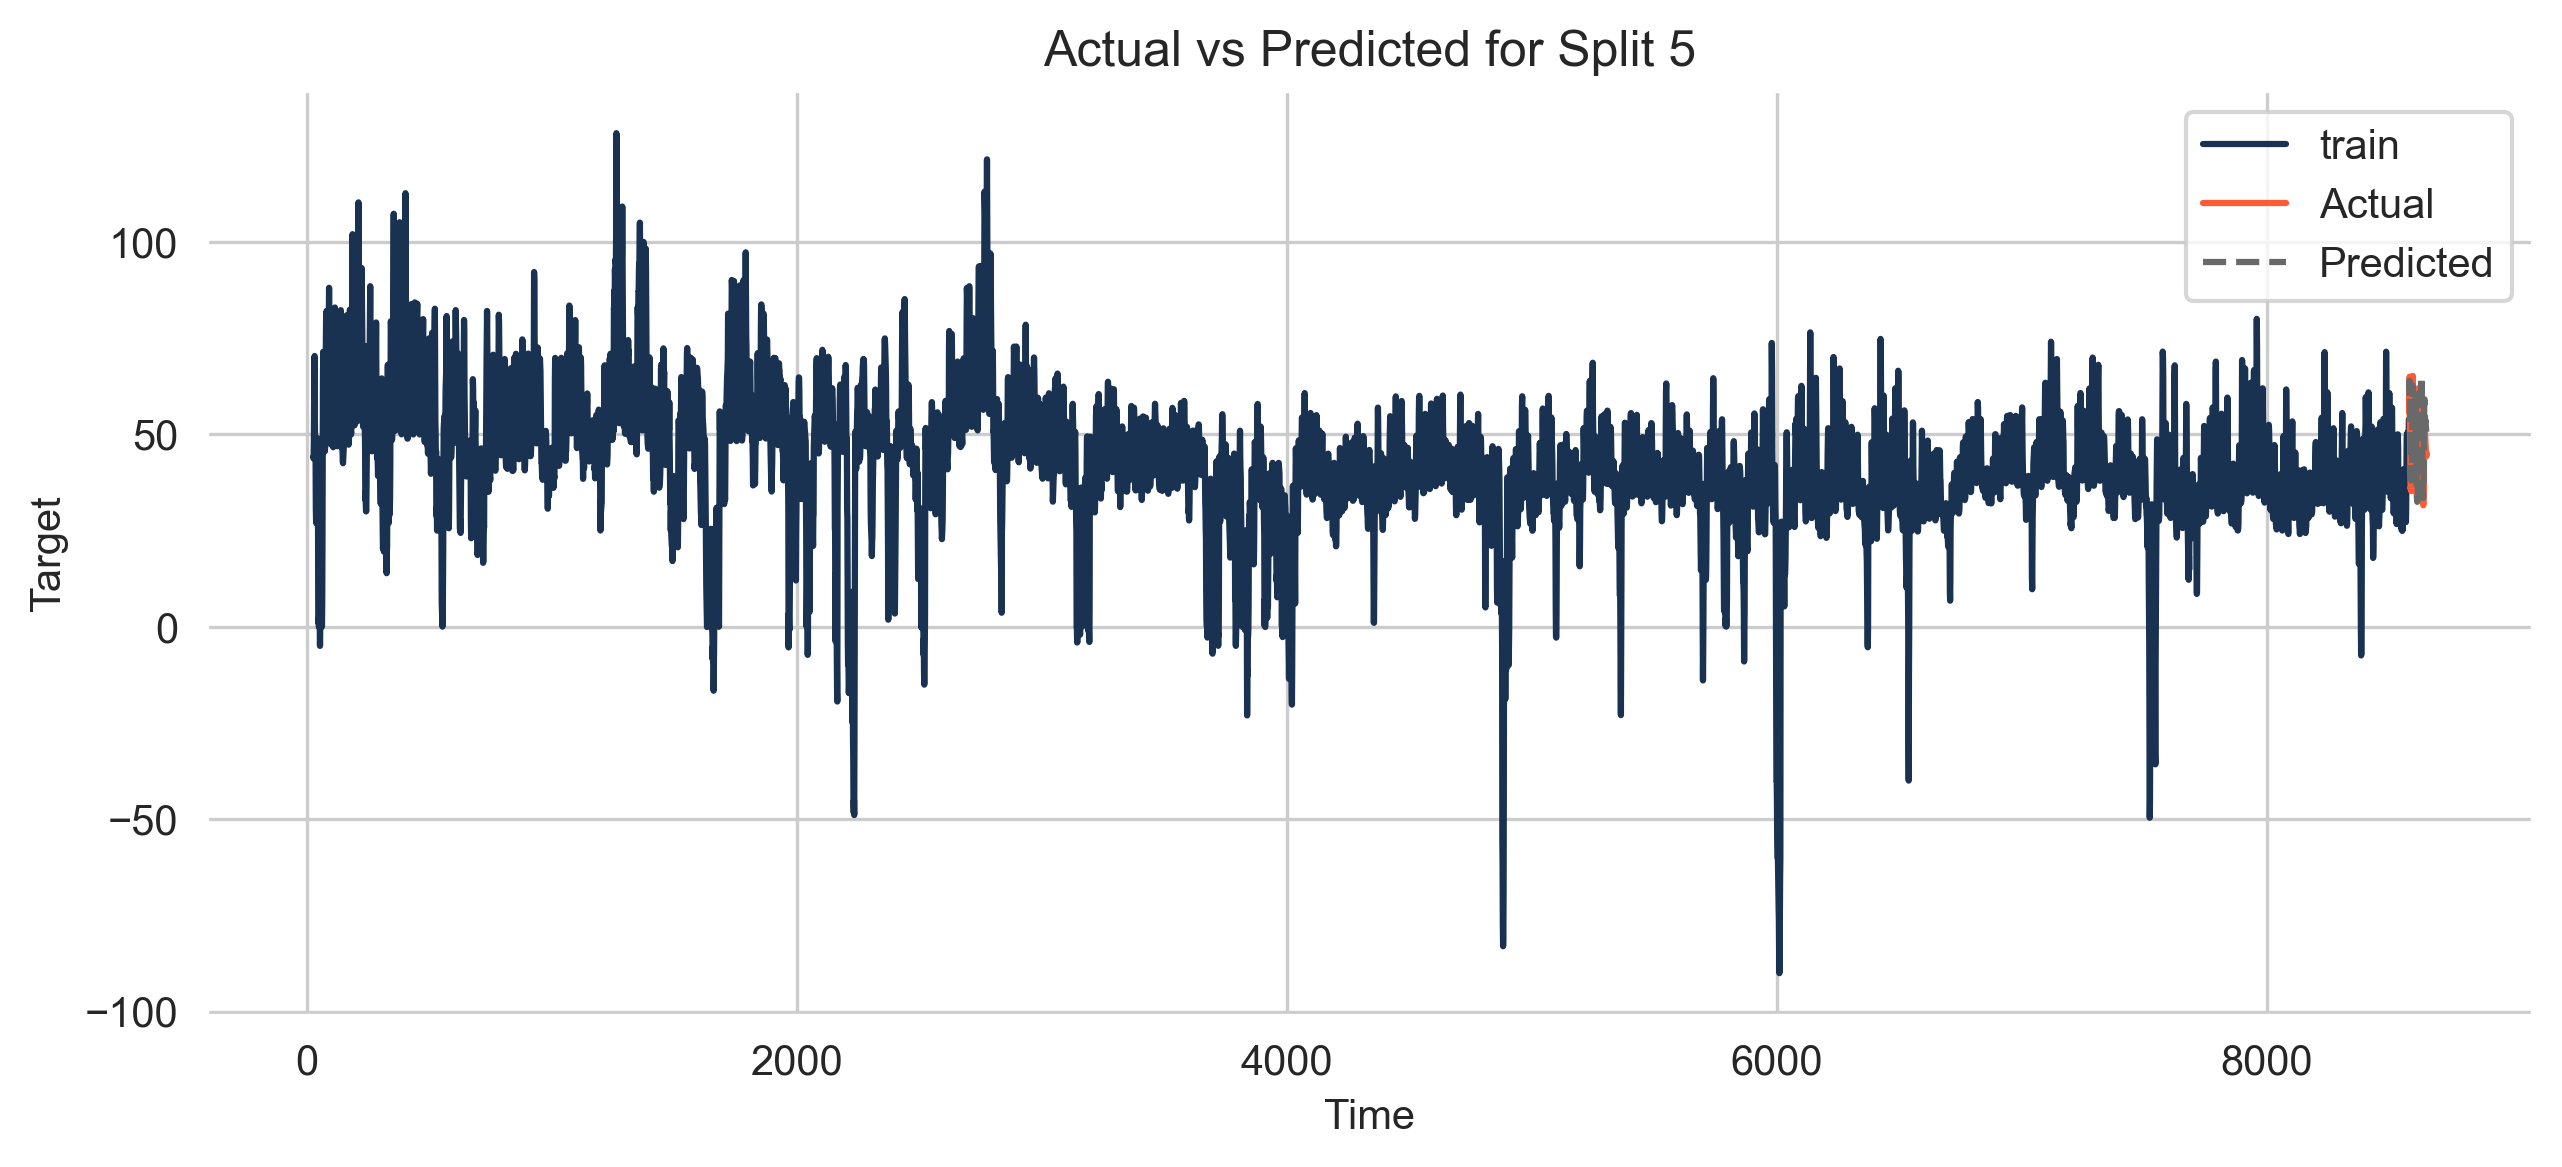

Split 5: Training data: (8558, 29), Validation data: (72, 29)
Training target: (8558,), Validation target: (72,)
MSE for Split 5: 24.994742392808128

Durchschnittliches MSE über alle Splits: 31.679507054042567


In [15]:

# Anzahl der Splits und Initialgröße des Trainingssets definieren
n_splits = 5
initial_train_size = int(len(X) / (n_splits + 1))
test_size = 72  # 72 Stunden

print(f"Initial train size: {initial_train_size}, Test size: {test_size}")

splits = []
mse_scores = []

for i in range(n_splits):
    train_end = initial_train_size + i * test_size
    test_end = train_end + test_size
    
    # Sicherstellen, dass train_end und test_end nicht über die Länge des Datensatzes hinausgehen
    if train_end >= len(X):
        break
    if test_end > len(X):
        test_end = len(X)

    X_train = X.iloc[:train_end]
    y_train = y.iloc[:train_end]
    X_test = X.iloc[train_end:test_end]
    y_test = y.iloc[train_end:test_end]
    
    # Sicherstellen, dass keine der Sets leer ist
    if len(X_train) == 0 or len(X_test) == 0 or len(y_train) == 0 or len(y_test) == 0:
        break
    
    splits.append((X_train, X_test, y_train, y_test))
    
    # Lineares Regressionsmodell initialisieren und trainieren
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    
    # Vorhersagen auf dem Testset machen
    y_pred = linreg.predict(X_test)
    
    # Mean Squared Error berechnen
    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)
    print(mse_scores)

    # Plotting mit Seaborn
    plt.figure(figsize=(10, 4))
    sns.lineplot(x=y_train.index, y=y_train, label='train')
    sns.lineplot(x=y_test.index, y=y_test, label='Actual')
    sns.lineplot(x=y_test.index, y=y_pred, label='Predicted', linestyle='--')
    plt.title(f'Actual vs Predicted for Split {i+1}')
    plt.xlabel('Time')
    plt.ylabel('Target')
    plt.legend()
    plt.show()

    print(f"Split {i+1}: Training data: {X_train.shape}, Validation data: {X_test.shape}")
    print(f"Training target: {y_train.shape}, Validation target: {y_test.shape}")
    print(f"MSE for Split {i+1}: {mse}\n")

# Durchschnittliches MSE über alle Splits zur Gesamtauswertung
if mse_scores:
    average_mse = sum(mse_scores) / len(mse_scores)
    print(f"Durchschnittliches MSE über alle Splits: {average_mse}")
else:
    print("Keine gültigen Splits gefunden.")
